# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 11

In [2]:
cluster = '11'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 408
Num noneffect sequences: 408


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
365   chr5  103214829  103214830      rs26257      T         C   C    T     C   
395   chr8   27369272   27369273     rs755951      A         C   A  C,T     A   
264  chr19   45326535   45326536     rs344791      C         G   G    C     C   
210  chr19   18438073   18438074    rs2303696      T         C   T    C     C   
351   chr4   89837895   89837896    rs2619363    NAN       NAN   G  C,T     G   
363   chr5  103120549  103120550      rs26523      T         C   C    T     C   
147  chr17   45894775   45894776   rs11575896      G         A   G    A     G   
218  chr19   44644418   44644419   rs10426401      T         G   T    G     T   
111  chr17   45741290   45741291   rs77114624      T         C   T    C     T   
318   chr3  122458998  122458999   rs56118506      T         C   C    T     C   
372   chr6   27762683   27762684    rs7759217      G         A   A    G     A   
77   chr16   70686726   70686727   rs35874206      C         G   G    C     G   
79   chr17    4901871    4901872   rs79436576      T         C   C    T     C   
136  chr17   45852871   45852872   rs79589869      C         A   C    A     C   
211  chr19   18462023   18462024    rs8103622      T         C   C    T     C   
94   chr17   45489970   45489971    rs1879586      G         C   C    G     C   
113  chr17   45747972   45747973   rs62054435      G         C   C    G     C   
148  chr17   45895214   45895215   rs74457229      T         C   C    T     C   
358   chr5  102971887  102971888    rs6881225      T         C   T    C     T   
400   chr8   27608663   27608664    rs1532277      T         C   T    C     C   
234  chr19   44890258   44890259  rs117310449      T         C   C    T     C   
263  chr19   45326123   45326124     rs344792      A         G   G    A     A   
40   chr12   40224294   40224295    rs1388597      G         A   A    G     A   
212  chr19   18495455   18495456   rs10411009      A         G   A  G,T     A   
73   chr16   31133897   31133898   rs12597511      T         C   C    T     C   
368   chr5  134587210  134587211   rs17167630      T         C   T    C     T   
334   chr4   89738183   89738184   rs78504001      T         A   A    T     A   
103  chr17   45719720   45719721   rs56167344      T         A   A  G,T     A   
203  chr18   51197068   51197069    rs4396619      T         C   C    T     C   
145  chr17   45894418   45894419   rs11575895      G         A   A    G     A   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
129  chr17   45819323   45819324   rs78074121      T         C   T    C     T   
247  chr19   44954888   44954889    rs3760629      A         C   A    C     C   
348   chr4   89836353   89836354    rs1372520      T         C   T    C     C   
361   chr5  103041308  103041309    rs6881612      T         C   C    T     C   
118  chr17   45748358   45748359   rs62054439      T         G   G    T     G   
350   chr4   89836583   89836584    rs2619361      C         A   C    A     C   
115  chr17   45748201   45748202   rs62054436      T         C   C    T     C   
38   chr12   40105791   40105792  rs139518863      T         C   C    T     C   
123  chr17   45818430   45818431    rs4309444      T         C   T    C     T   
26   chr11   83779929   83779930     rs896313      T         C   T    C     T   
341   chr4   89766355   89766356    rs3796661      T         C   C    T     C   
287   chr2  168247488  168247489   rs76179989      T         G   T    G     T   
336   chr4   89753279   89753280     rs356168      A         G   G    A     G   
153  chr17   45896046   45896047   rs78720789      G         A   A    G     A   
398   chr8   27516347   27516348     rs751141      A         G   G    A     G   
308   chr3   52308077   52308078  rs145746673      G         C   G    C     G   
100  chr17   45667623   45667624   rs17687462      T         C   C    T     C   
388   chr7  100226829  100226830     r

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs26257   ||    chr5 : 103214829 - 103214830   ||    Locus: 365   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  9.34E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.0362   ||   Center / 200bp : 0.0634
Noneffect Sequence : GTCCATCAACGGTAGACTGG


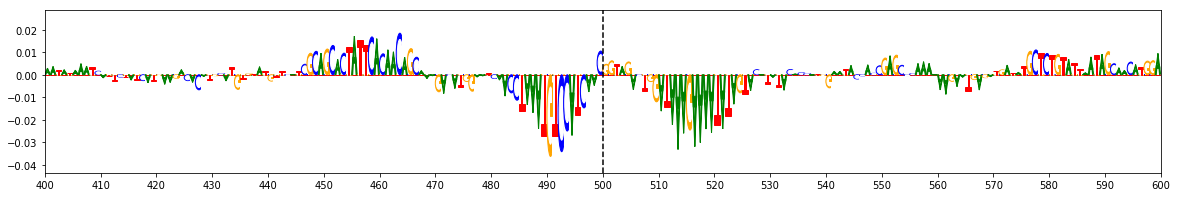

Effect Allele : T   ||   Explain Score : 0.0006   ||   Center / 200bp : 0.0011
Effect Sequence : GTCCATCAATGGTAGACTGG


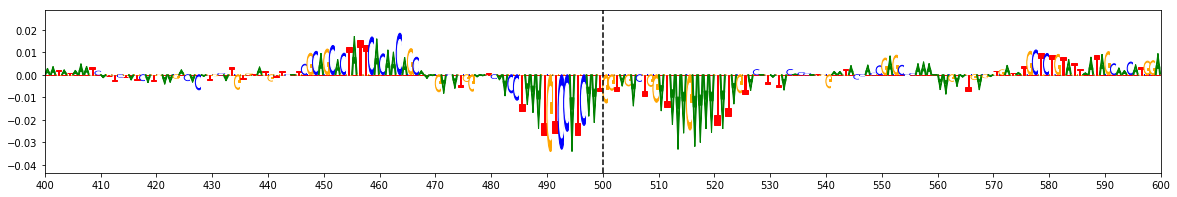

Allele Ratio : 0.0166   ||   Allele Difference : -0.1391  ||  ISM Score : -0.2193  ||  deltaSVM Score : -1.2458


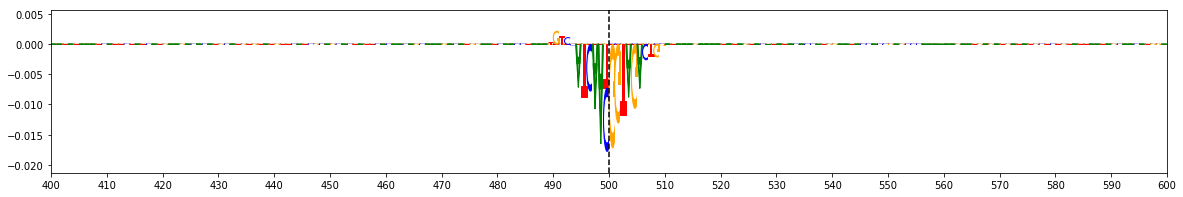


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 395   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  1.99E-07
Alzheimers_Jansen_2018 		  1.31E-11
Alzheimers_Kunkle_2019 		  3.79E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.5812   ||   Center / 200bp : 0.7241
Noneffect Sequence : TTCACTGGCCTGTAGGGGGA


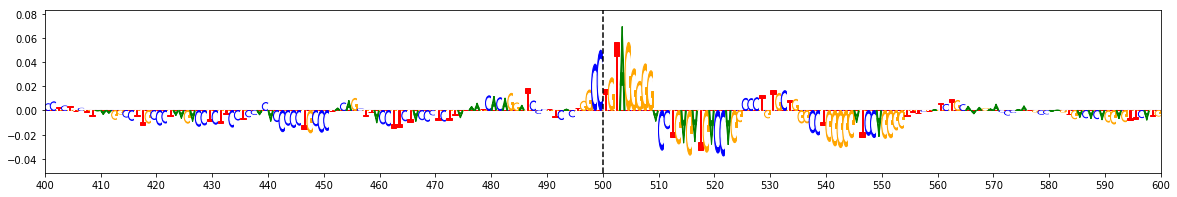

Effect Allele : A   ||   Explain Score : 0.2188   ||   Center / 200bp : 0.4969
Effect Sequence : TTCACTGGCATGTAGGGGGA


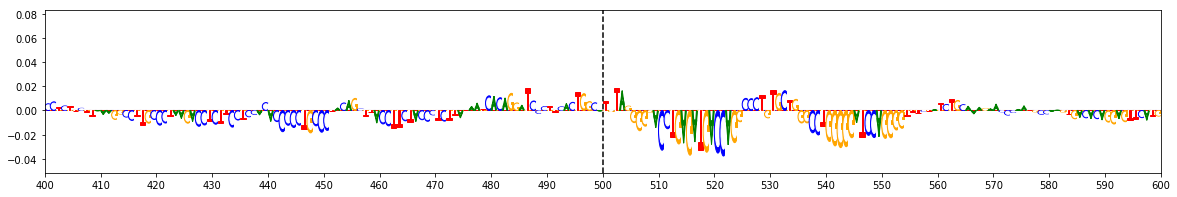

Allele Ratio : 0.3765   ||   Allele Difference : -0.3929  ||  ISM Score : -0.6134  ||  deltaSVM Score : -3.5422


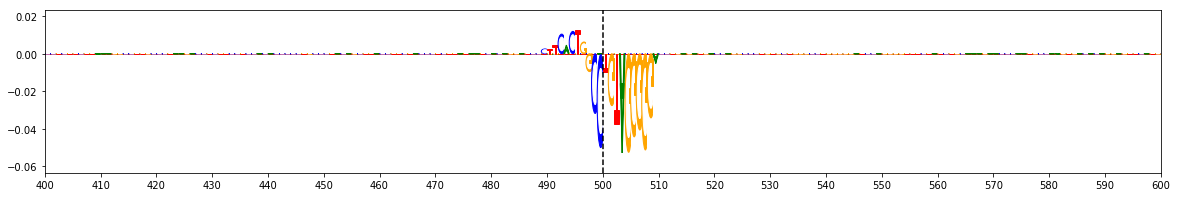


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 264   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1215   ||   Center / 200bp : 0.2575
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


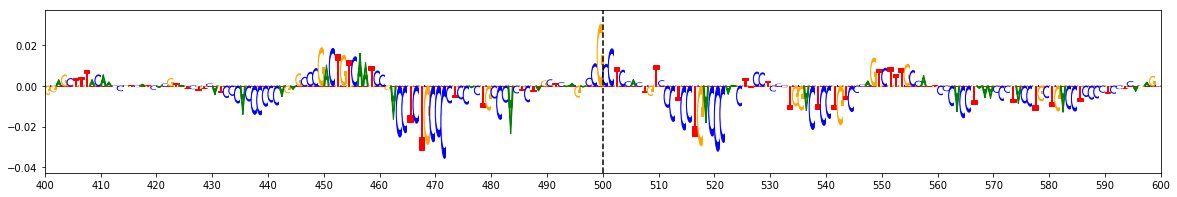

Effect Allele : C   ||   Explain Score : 0.0168   ||   Center / 200bp : 0.0463
Effect Sequence : CTCAAGACCCCCTCCACTGT


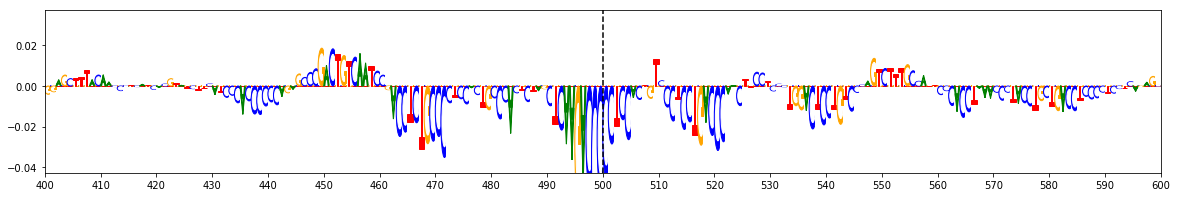

Allele Ratio : 0.1385   ||   Allele Difference : -0.6391  ||  ISM Score : -1.0254  ||  deltaSVM Score : -5.918


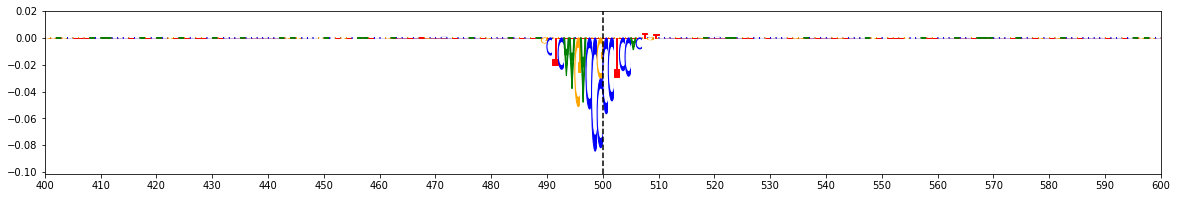


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 210   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.822   ||   Center / 200bp : 0.5009
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


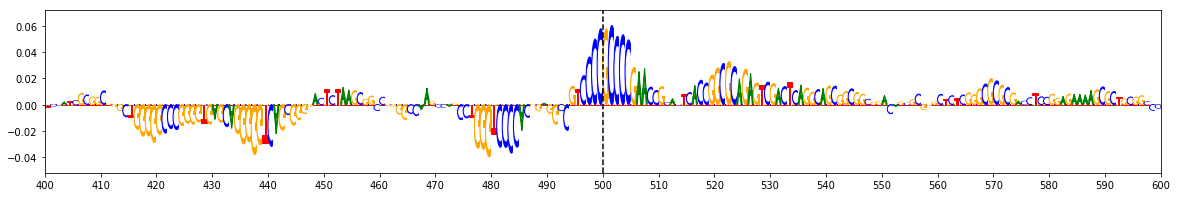

Effect Allele : T   ||   Explain Score : 0.3012   ||   Center / 200bp : 0.2679
Effect Sequence : GGCCGTCCCTGCCCCGAACC


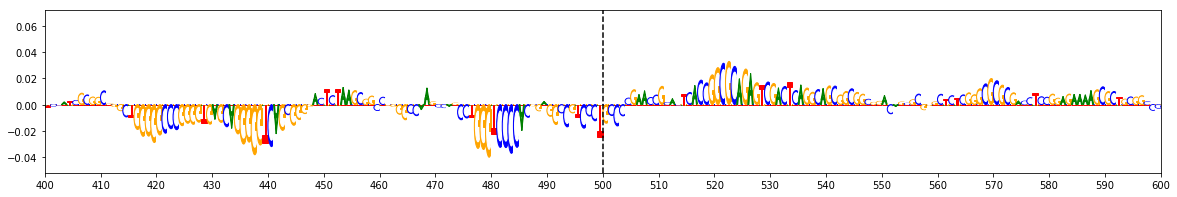

Allele Ratio : 0.3664   ||   Allele Difference : -0.6511  ||  ISM Score : -1.0441  ||  deltaSVM Score : -5.9291


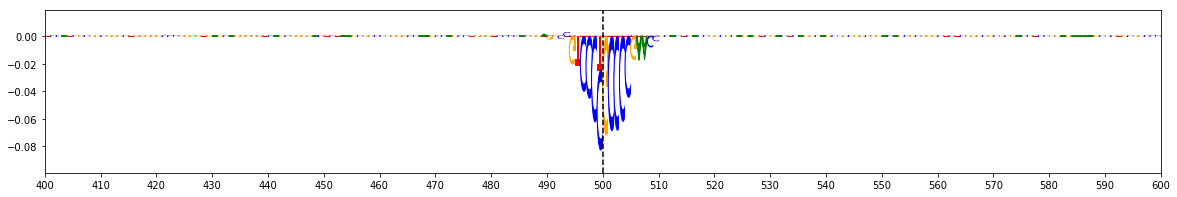


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 351   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.4519   ||   Center / 200bp : 0.6049
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


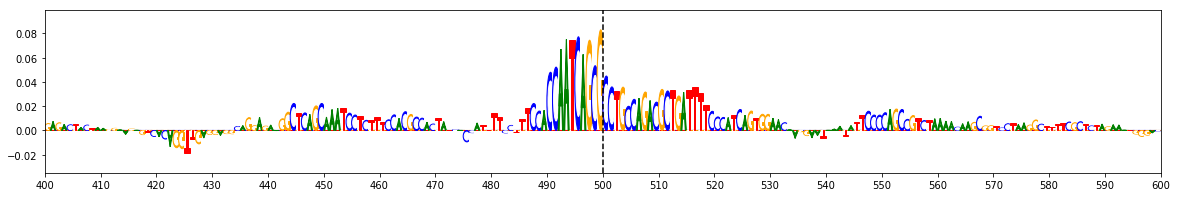

Effect Allele : NAN   ||   Explain Score : 0.758   ||   Center / 200bp : 0.4423
Effect Sequence : CCAATCAGCCCCTGCCAGAC


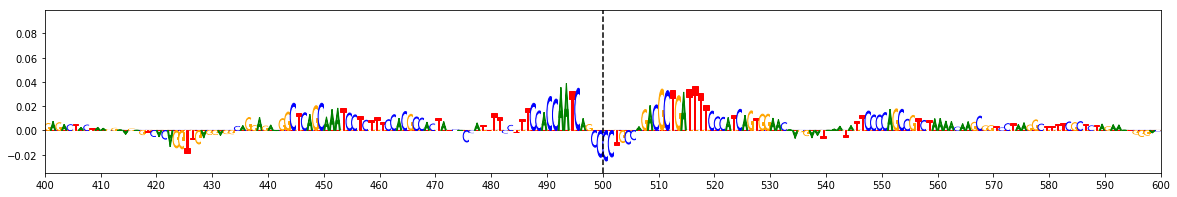

Allele Ratio : 0.5221   ||   Allele Difference : -0.8179  ||  ISM Score : -1.2473  ||  deltaSVM Score : -7.4844


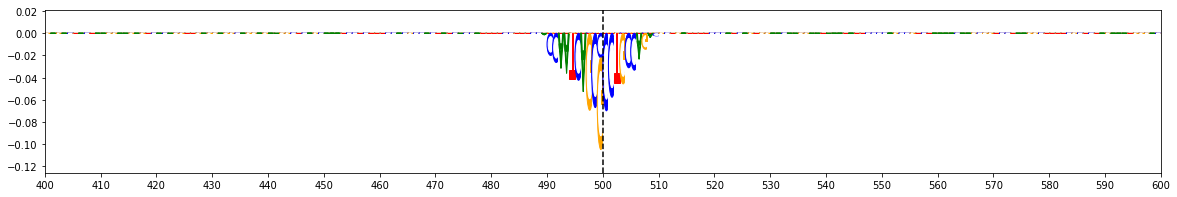


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 363   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.4677   ||   Center / 200bp : 0.2909
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


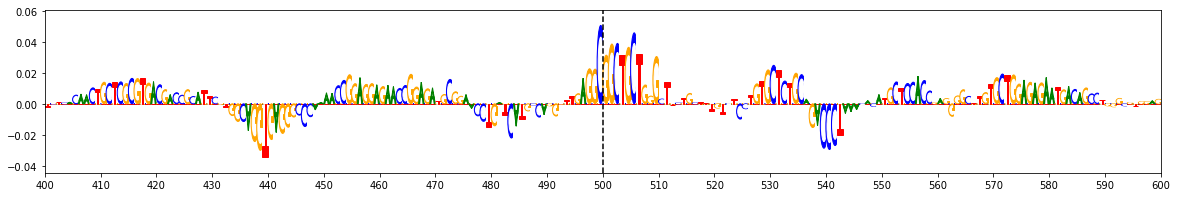

Effect Allele : T   ||   Explain Score : 0.1186   ||   Center / 200bp : 0.0943
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


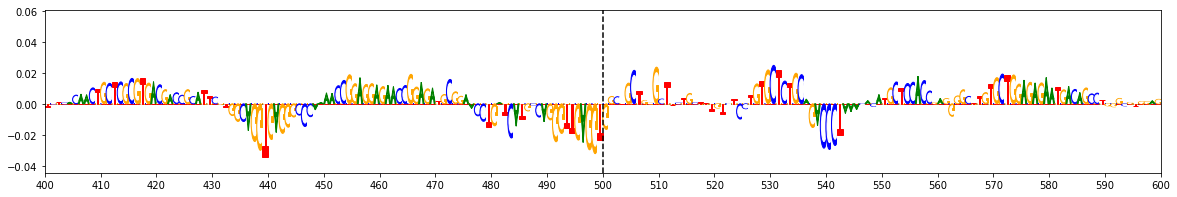

Allele Ratio : 0.2536   ||   Allele Difference : -0.5827  ||  ISM Score : -0.9115  ||  deltaSVM Score : -5.2627


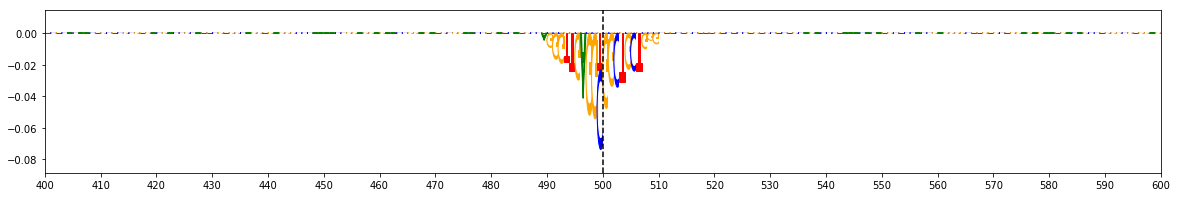


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 147   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.7814   ||   Center / 200bp : 0.6451
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


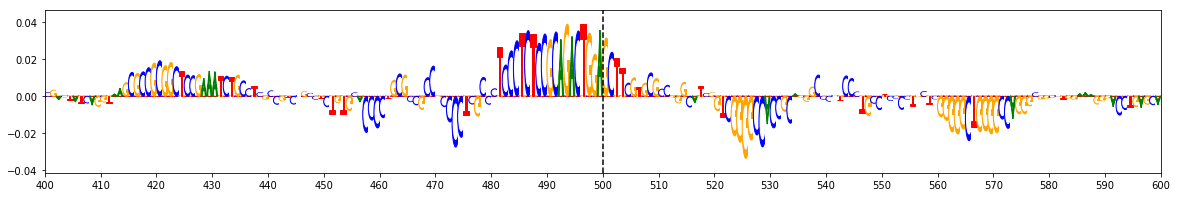

Effect Allele : G   ||   Explain Score : 0.4703   ||   Center / 200bp : 0.5227
Effect Sequence : GCAGACTGGGGCTTCGTGCG


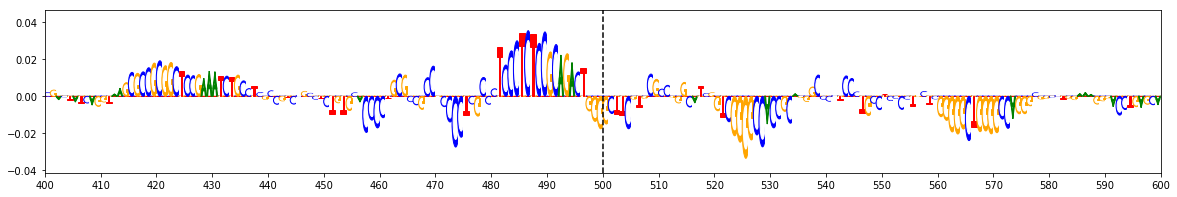

Allele Ratio : 0.6019   ||   Allele Difference : -0.42  ||  ISM Score : -0.6747  ||  deltaSVM Score : -3.8613


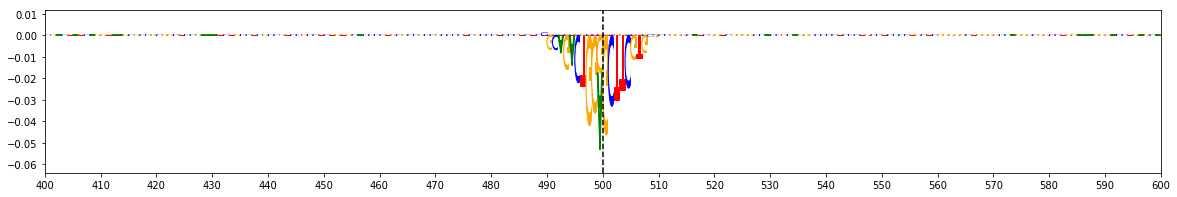


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 218   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6089   ||   Center / 200bp : 0.449
Noneffect Sequence : CAACACGGGGCGGGCACAAG


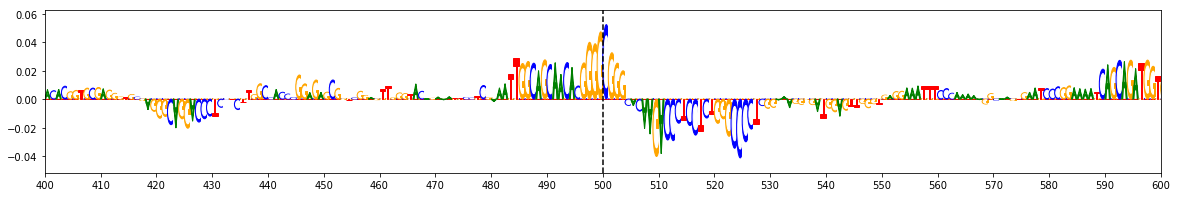

Effect Allele : T   ||   Explain Score : 0.2808   ||   Center / 200bp : 0.2727
Effect Sequence : CAACACGGGTCGGGCACAAG


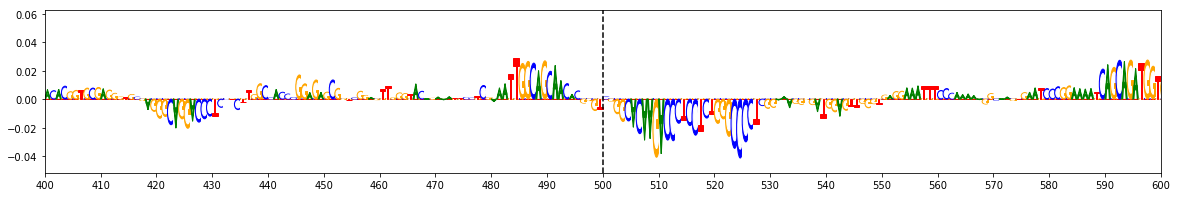

Allele Ratio : 0.4611   ||   Allele Difference : -0.4288  ||  ISM Score : -0.6832  ||  deltaSVM Score : -3.9077


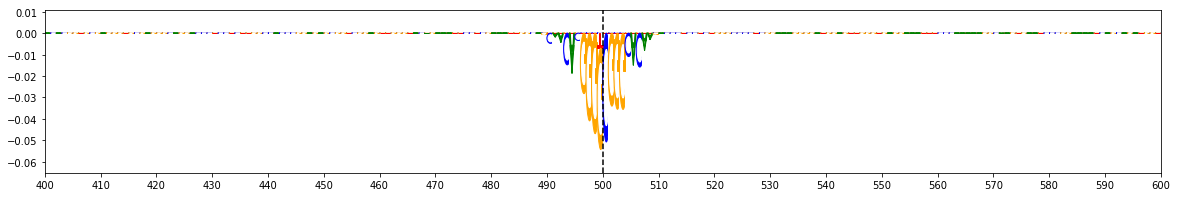


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs77114624   ||    chr17 : 45741290 - 45741291   ||    Locus: 111   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.91E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.2724   ||   Center / 200bp : 0.311
Noneffect Sequence : ACAAGGCATCGCTCTGGGCA


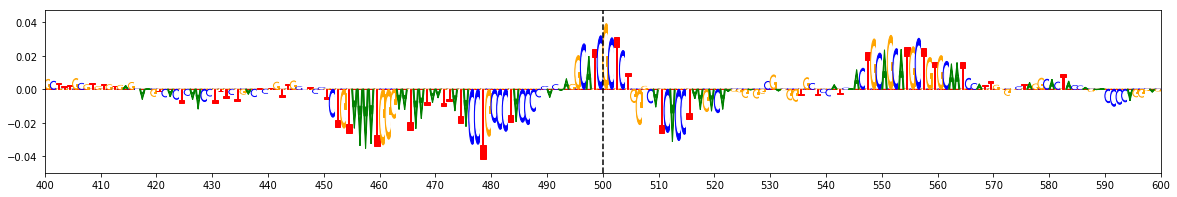

Effect Allele : T   ||   Explain Score : 0.089   ||   Center / 200bp : 0.1286
Effect Sequence : ACAAGGCATTGCTCTGGGCA


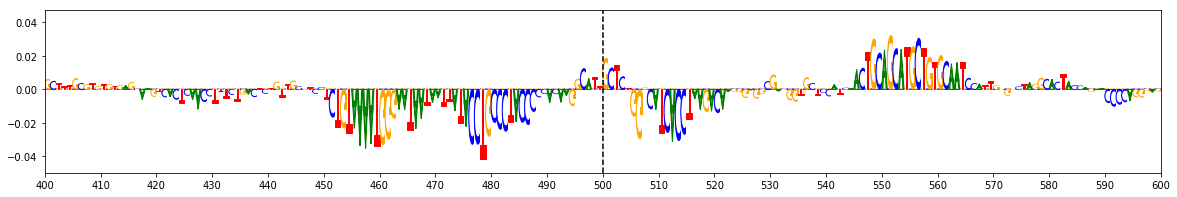

Allele Ratio : 0.3267   ||   Allele Difference : -0.234  ||  ISM Score : -0.3674  ||  deltaSVM Score : -2.1148


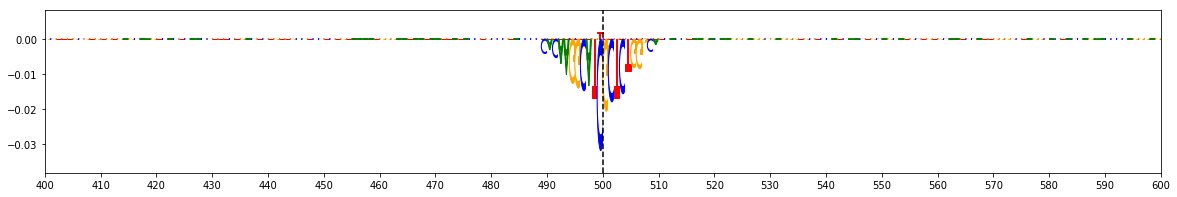


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56118506   ||    chr3 : 122458998 - 122458999   ||    Locus: 318   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  5.45E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9295   ||   Center / 200bp : 0.6128
Noneffect Sequence : TTATCACTTCCGGAGGAATC


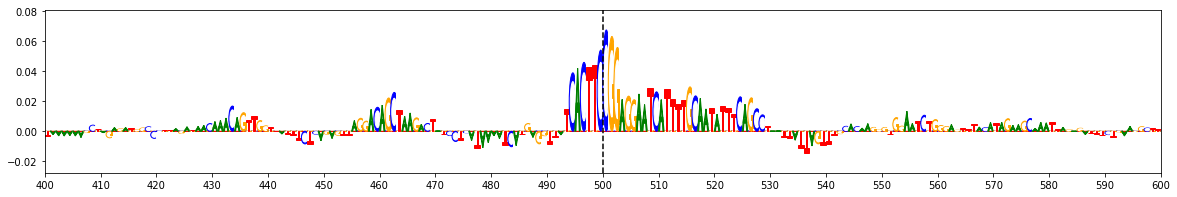

Effect Allele : T   ||   Explain Score : 0.6042   ||   Center / 200bp : 0.5072
Effect Sequence : TTATCACTTTCGGAGGAATC


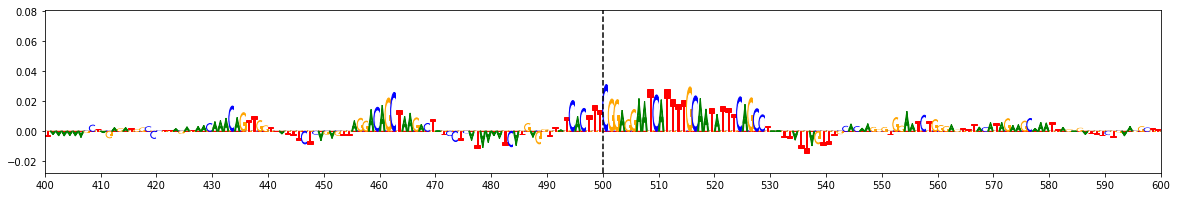

Allele Ratio : 0.6499   ||   Allele Difference : -0.3111  ||  ISM Score : -0.4847  ||  deltaSVM Score : -2.7443


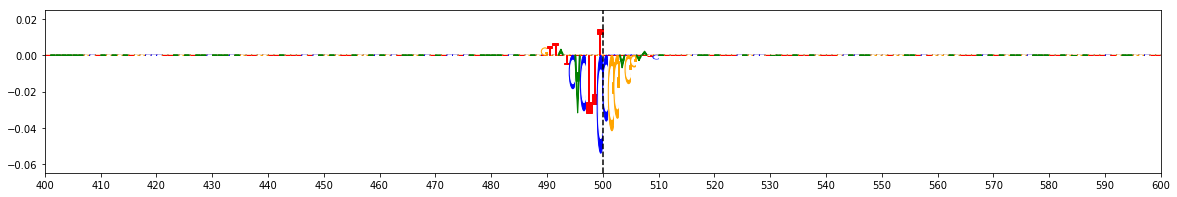


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7759217   ||    chr6 : 27762683 - 27762684   ||    Locus: 372   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.64E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.9535   ||   Center / 200bp : 0.6891
Noneffect Sequence : ACAGCGCAGATAGGGTTGTT


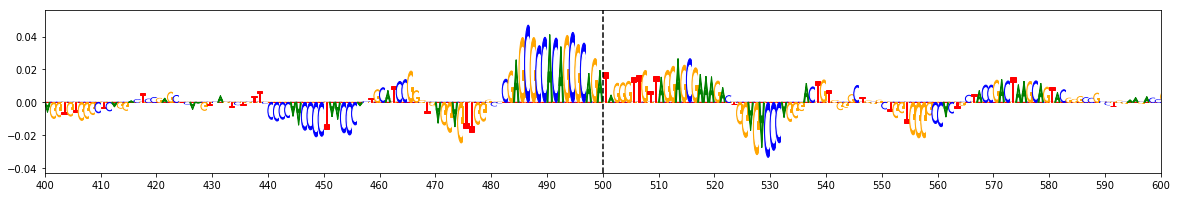

Effect Allele : G   ||   Explain Score : 0.7043   ||   Center / 200bp : 0.6208
Effect Sequence : ACAGCGCAGGTAGGGTTGTT


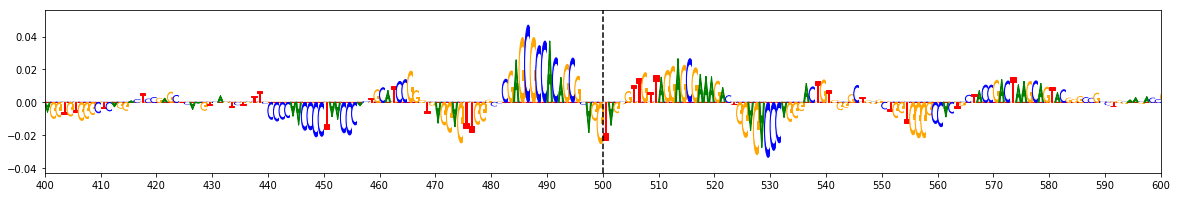

Allele Ratio : 0.7386   ||   Allele Difference : -0.3487  ||  ISM Score : -0.5452  ||  deltaSVM Score : -3.1494


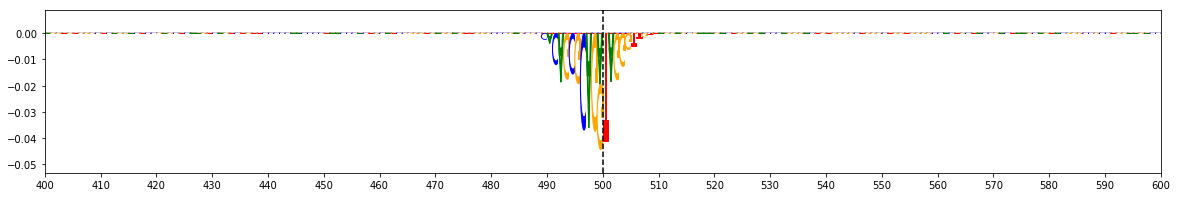


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35874206   ||    chr16 : 70686726 - 70686727   ||    Locus: 77   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  4.19E-04
Alzheimers_Lambert_2013 	  7.97E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8813   ||   Center / 200bp : 0.7565
Noneffect Sequence : AGAGCTGGAGTGTCCTTGGT


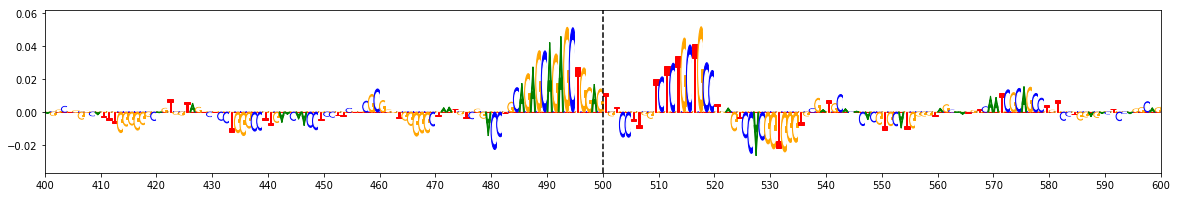

Effect Allele : C   ||   Explain Score : 0.7202   ||   Center / 200bp : 0.7171
Effect Sequence : AGAGCTGGACTGTCCTTGGT


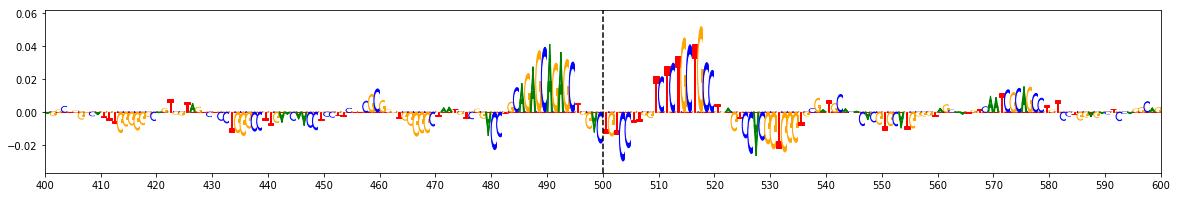

Allele Ratio : 0.8172   ||   Allele Difference : -0.2587  ||  ISM Score : -0.4072  ||  deltaSVM Score : -2.3382


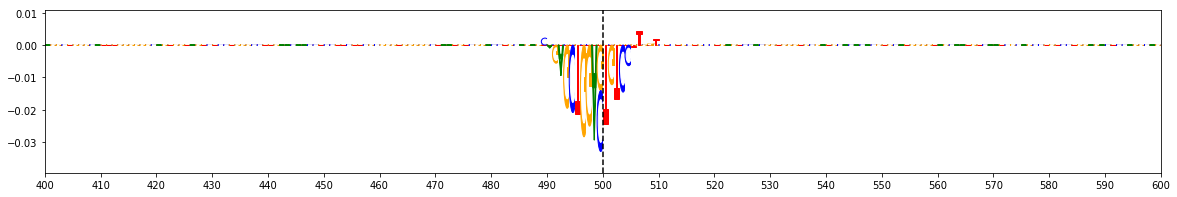


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 79   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  3.06E-04
Alzheimers_Lambert_2013 	  4.79E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.4298   ||   Center / 200bp : 0.4269
Noneffect Sequence : CGGTTGGCCCCGCCCCATAA


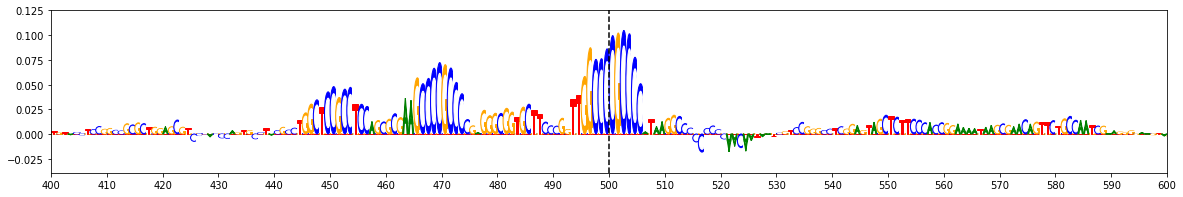

Effect Allele : T   ||   Explain Score : 0.6597   ||   Center / 200bp : 0.2534
Effect Sequence : CGGTTGGCCTCGCCCCATAA


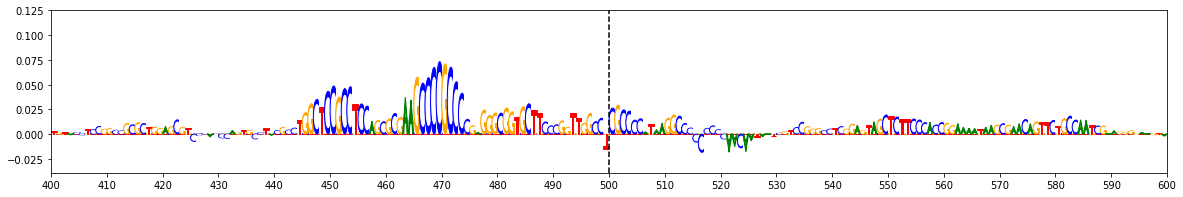

Allele Ratio : 0.4614   ||   Allele Difference : -0.7864  ||  ISM Score : -1.2271  ||  deltaSVM Score : -7.2212


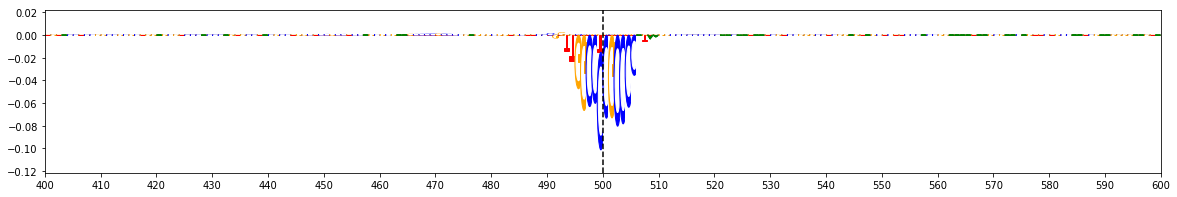


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 136   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.4026   ||   Center / 200bp : 0.8695
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


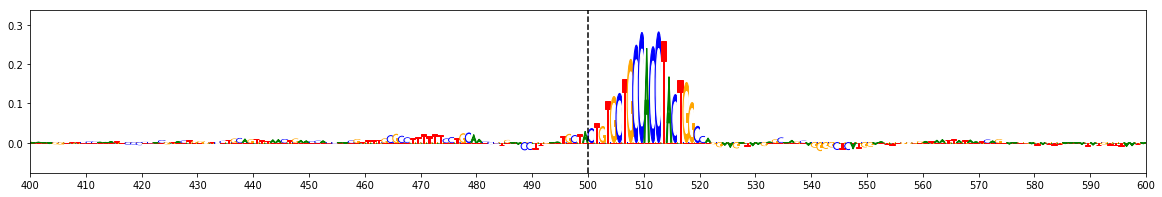

Effect Allele : C   ||   Explain Score : 3.2596   ||   Center / 200bp : 0.8645
Effect Sequence : TTGAATGCTCCTGTGCTGCC


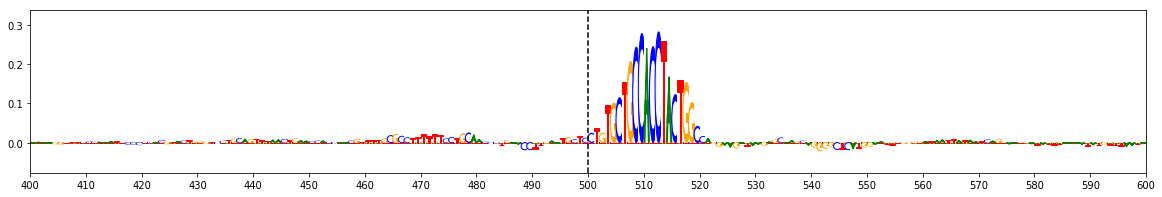

Allele Ratio : 0.958   ||   Allele Difference : -0.1432  ||  ISM Score : -0.2245  ||  deltaSVM Score : -1.2842


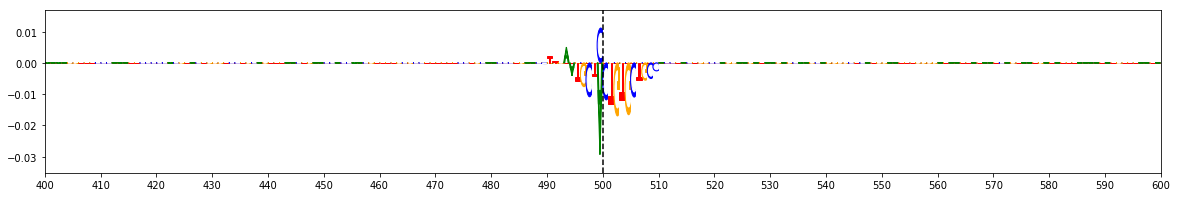


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 211   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 2.2322   ||   Center / 200bp : 0.6977
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


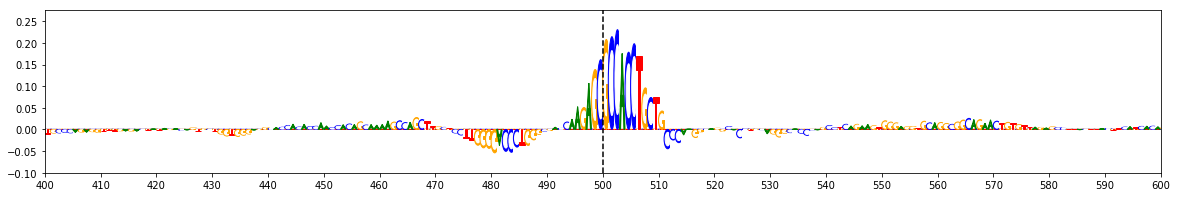

Effect Allele : T   ||   Explain Score : 1.7454   ||   Center / 200bp : 0.6436
Effect Sequence : GACCAAGAGTGCCACCTGCT


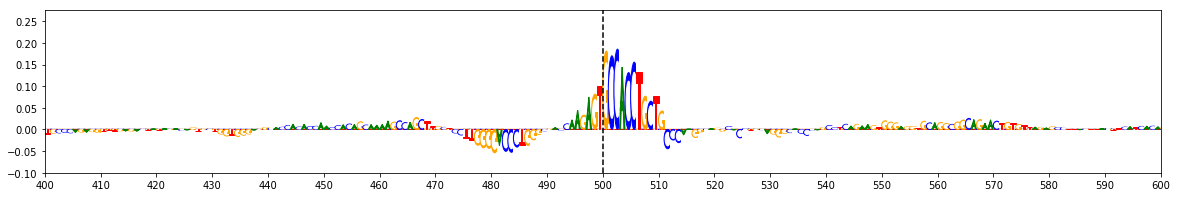

Allele Ratio : 0.7819   ||   Allele Difference : -0.486  ||  ISM Score : -0.7986  ||  deltaSVM Score : -4.5708


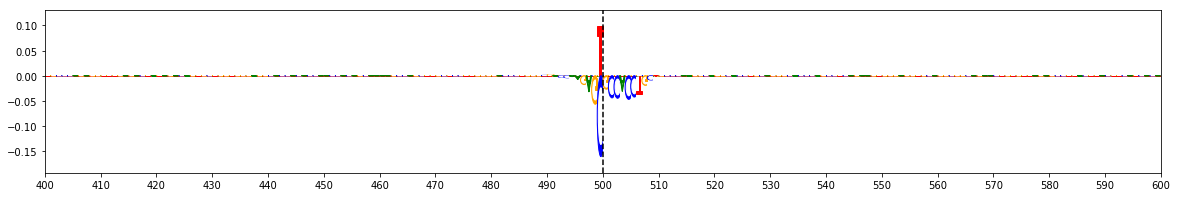


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1879586   ||    chr17 : 45489970 - 45489971   ||    Locus: 94   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.91E-21

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6357   ||   Center / 200bp : 0.567
Noneffect Sequence : AGGGATGGGCTGTCCTCAGT


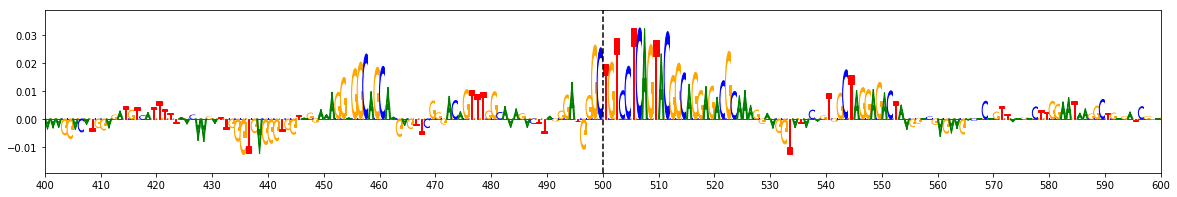

Effect Allele : G   ||   Explain Score : 0.4048   ||   Center / 200bp : 0.4549
Effect Sequence : AGGGATGGGGTGTCCTCAGT


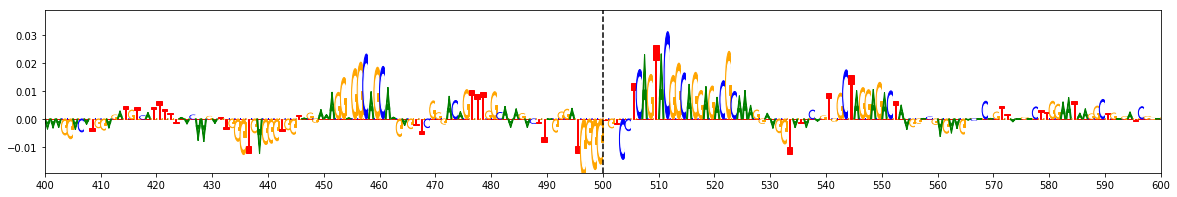

Allele Ratio : 0.6369   ||   Allele Difference : -0.3272  ||  ISM Score : -0.5097  ||  deltaSVM Score : -2.9233


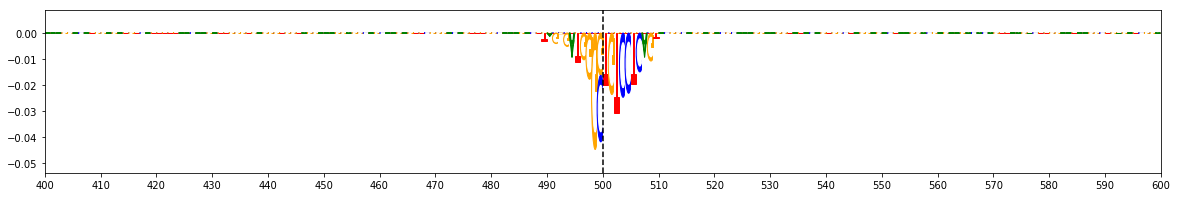


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054435   ||    chr17 : 45747972 - 45747973   ||    Locus: 113   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.95E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.5679   ||   Center / 200bp : 0.7846
Noneffect Sequence : CTTTCTGTGCAGAAGGCTGG


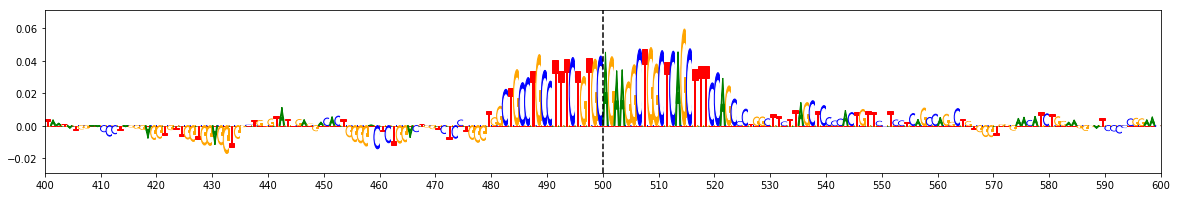

Effect Allele : G   ||   Explain Score : 1.4316   ||   Center / 200bp : 0.7689
Effect Sequence : CTTTCTGTGGAGAAGGCTGG


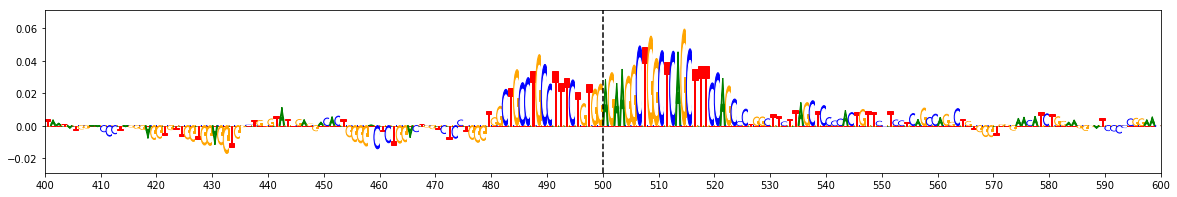

Allele Ratio : 0.9131   ||   Allele Difference : -0.1363  ||  ISM Score : -0.2062  ||  deltaSVM Score : -1.2173


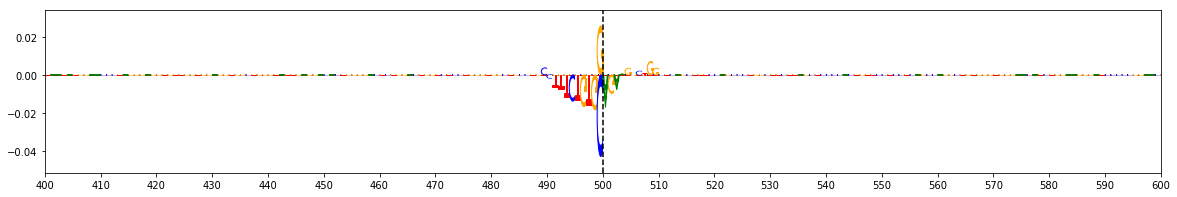


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74457229   ||    chr17 : 45895214 - 45895215   ||    Locus: 148   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6698   ||   Center / 200bp : 0.5828
Noneffect Sequence : ACGCCCCTCCCTGCACCTCC


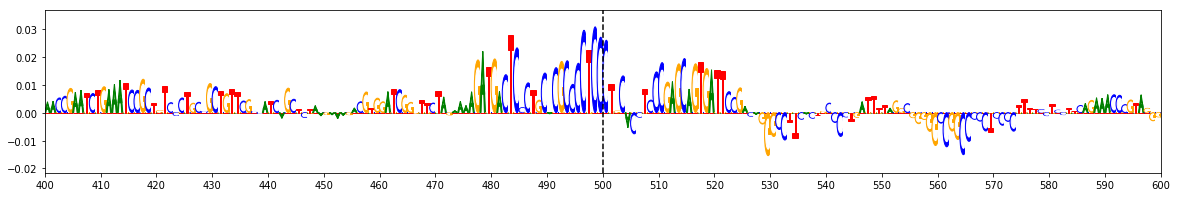

Effect Allele : T   ||   Explain Score : 0.465   ||   Center / 200bp : 0.4905
Effect Sequence : ACGCCCCTCTCTGCACCTCC


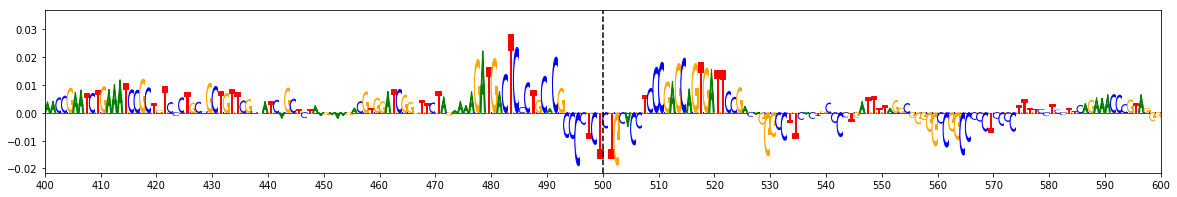

Allele Ratio : 0.6943   ||   Allele Difference : -0.3345  ||  ISM Score : -0.5545  ||  deltaSVM Score : -3.2813


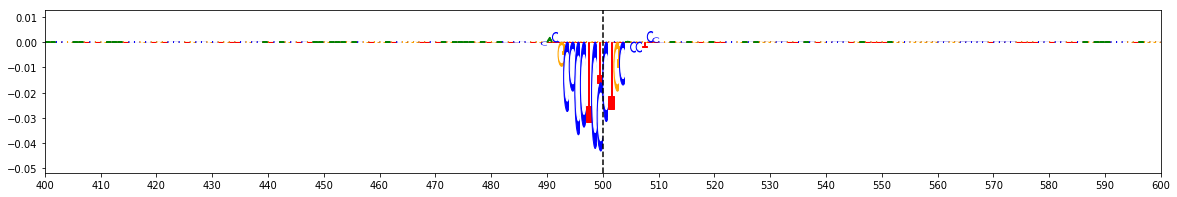


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 358   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.8874   ||   Center / 200bp : 0.7368
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


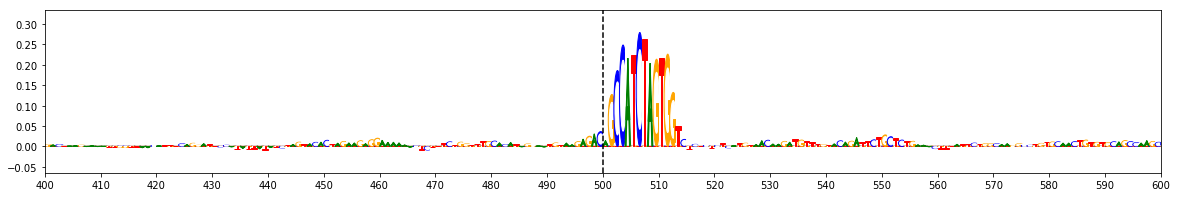

Effect Allele : T   ||   Explain Score : 2.5675   ||   Center / 200bp : 0.7136
Effect Sequence : TGTAAGAGATAGCCATCTAG


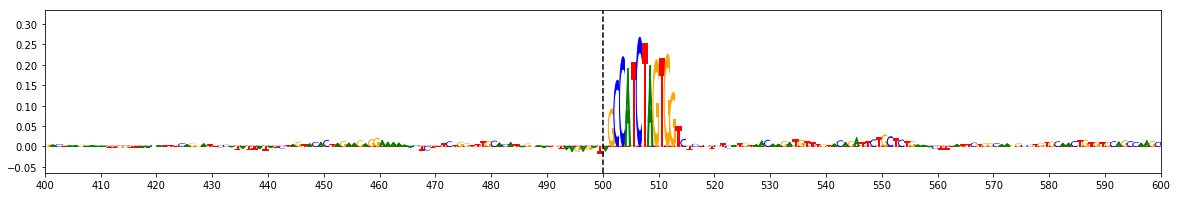

Allele Ratio : 0.8892   ||   Allele Difference : -0.4077  ||  ISM Score : -0.64  ||  deltaSVM Score : -3.639


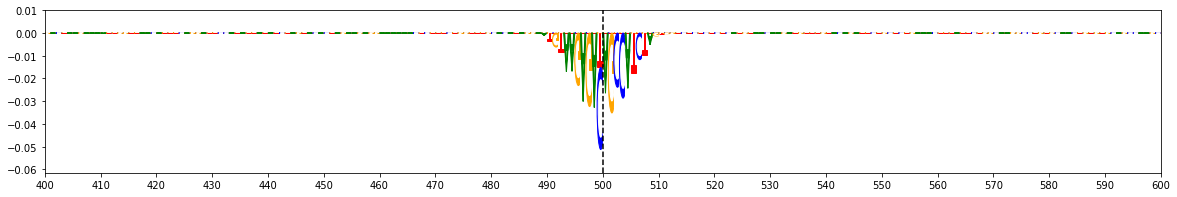


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1532277   ||    chr8 : 27608663 - 27608664   ||    Locus: 400   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  4.63E-19
Alzheimers_Kunkle_2019 		  3.79E-16
Alzheimers_Lambert_2013 	  3.06E-16

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8896   ||   Center / 200bp : 0.7445
Noneffect Sequence : GAACTAGCACGTGATCAGGG


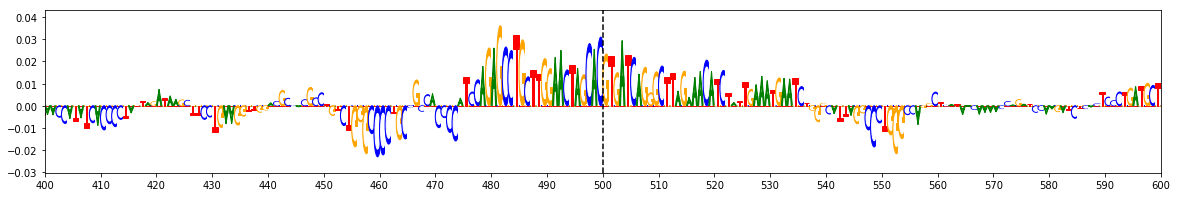

Effect Allele : T   ||   Explain Score : 0.8039   ||   Center / 200bp : 0.7248
Effect Sequence : GAACTAGCATGTGATCAGGG


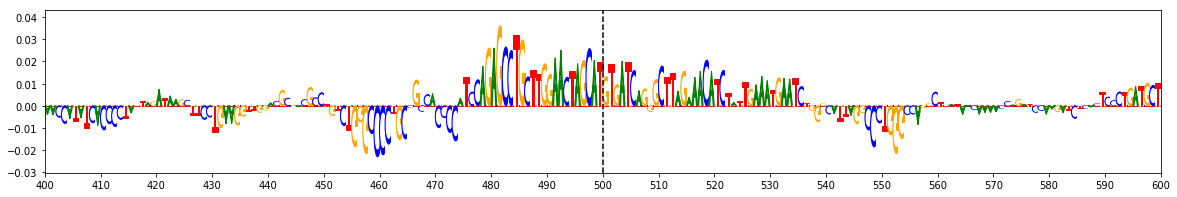

Allele Ratio : 0.9036   ||   Allele Difference : -0.0883  ||  ISM Score : -0.137  ||  deltaSVM Score : -0.8145


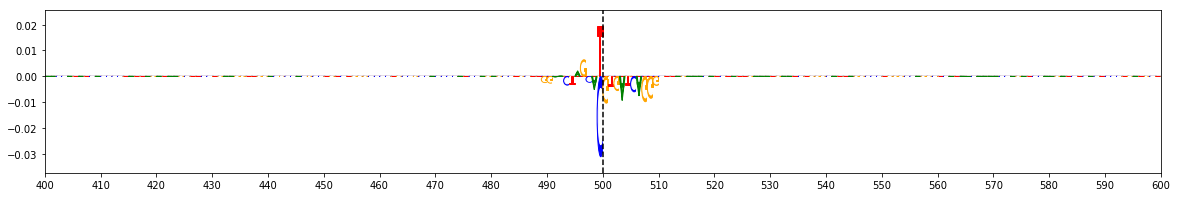


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
135  chr17   45852666   45852667   rs62054825      G         A   G      A   
156  chr17   45896863   45896864   rs62056782      T         C   C      T   
369   chr5  134594837  134594838   rs17167632      G         A   G      A   
353   chr4   90290372   90290373   rs75541595      G         A   G      A   
305   chr3   49120337   49120338    rs6779394      G         A   G    A,C   
29   chr11   83780713   83780714    rs4143315      C         A   C    A,T   
339   chr4   89754086   89754087    rs3857059      G         A   A    G,T   
340   chr4   89765967   89765968    rs3775427      G         A   G      A   
258  chr19   45039212   45039213   rs34034621      T         C   C      T   
59   chr16   30010080   30010081    rs1140239    NAN       NAN   C    A,T   
245  chr19   44954309   44954310    rs7245611      C         T   T    C,G   
202  chr18   51153618   51153619    rs7242459      C         A   C    A,G   
285   chr2  134719288  134719289   rs62171396      T         C   C      T   
186  chr17   46771150   46771151     rs199523      C         A   C      A   
112  chr17   45741323   45741324   rs76311426      T         G   G      T   
383   chr7   23115905   23115906   rs73272053    NAN       NAN   A      G   
158  chr17   45897109   45897110   rs80346216      T         G   G      T   
273   chr2  127084806  127084807   rs11691237      T         C   C      T   
7    chr10   80493944   80493945    rs7900536      A         C   C    A,T   
226  chr19   44806777   44806778   rs28399596      A         G   G      A   
319   chr3  122459017  122459018   rs55793255      G         A   A      G   
356   chr5  102910380  102910381   rs35100629      G         C   C      G   
206  chr19    1040765    1040766    rs4147904      A         G   A      G   
163  chr17   45942276   45942277   rs62062769      G         A   G      A   
180  chr17   46213392   46213393    rs2668662      T         C   T      C   
143  chr17   45894114   45894115   rs80233201      T         C   T      C   
399   chr8   27608639   27608640    rs1532276      T         C   T      C   
283   chr2  134718389  134718390   rs62171393      G         C   C      G   
304   chr3   49077110   49077111    rs7626445      T         C   C      T   
329   chr4     987143     987144   rs10902762      G         A   G      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
87   chr17   44220262   44220263  rs113844752      C         A   C    A,G   
0     chr1  155135690  155135691   rs12726330      G         A   G    A,C   
214  chr19   18495661   18495662   rs34256197      A         G   G      A   
326   chr4     973656     973657   rs13137144      G         A   G    A,C   
298   chr3   48898149   48898150    rs7431710      G         A   G    A,C   
406   chr9   17579691   17579692   rs13294100      T         G   T      G   
160  chr17   45897182   45897183   rs62056783      G         C   G      C   
67   chr16   30958235   30958236   rs62055866      G         C   G      C   
223  chr19   44758447   44758448   rs34967149      T         C   C      T   
170  chr17   46002200   46002201   rs17573447      T         C   C      T   
69   chr16   31011317   31011318   rs72800847      G         A   G      A   
324   chr4     968130     968131   rs62294486      T         C   C    A,T   
72   chr16   31074148   31074149    rs2303222      T         C   T    A,C   
89   chr17   45425917   45425918   rs76344126      G         A   G      A   
44   chr14   54901908   54901909    rs2149482      T         C   C      T   
154  chr17   45896131   45896132    rs4792891      T         G   T      G   
42   chr12  122836031  122836032   rs12820345      T         G   G      T   
392   chr8   22604860   22604861    rs3735901      T         C   T      C   
240  chr19   44915228   44915229   rs12691088      A         G   G    A,C   
338   chr4   89753299   89753300    rs3756054      T         C   T      C   
224

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 135   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.3923   ||  Center / 200bp: 0.8325
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


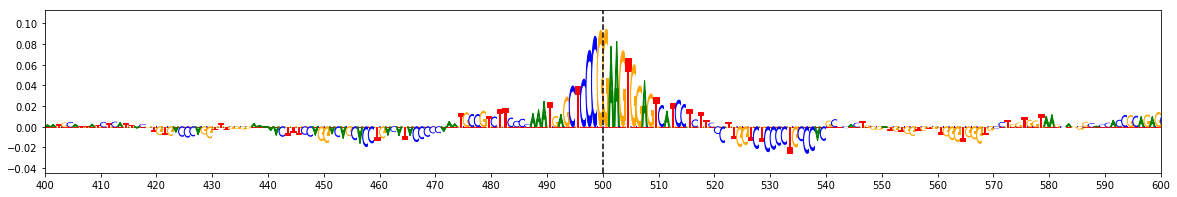

Noneffect Allele: A   ||  Explain Score: 0.5682   ||  Center / 200bp: 0.6696
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


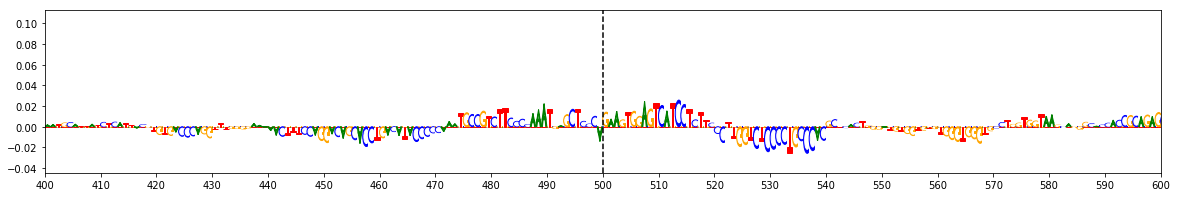

Allele Ratio : 2.4504   ||   Allele Difference : 0.8399  ||  ISM Score : 1.3147  ||  deltaSVM Score : 7.5471


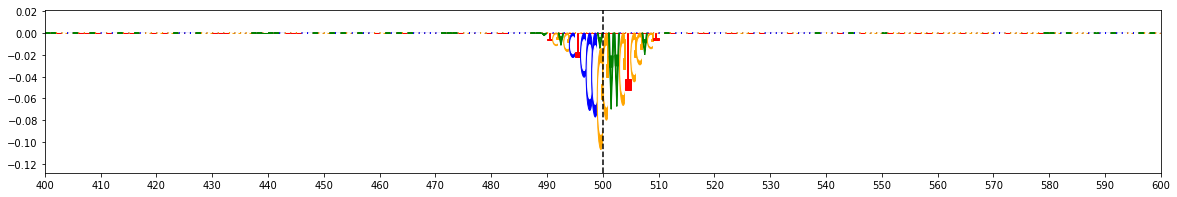


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 156   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.5339   ||  Center / 200bp: 0.7409
Effect Sequence: CTCGCCCTCTTGTGATGAAC


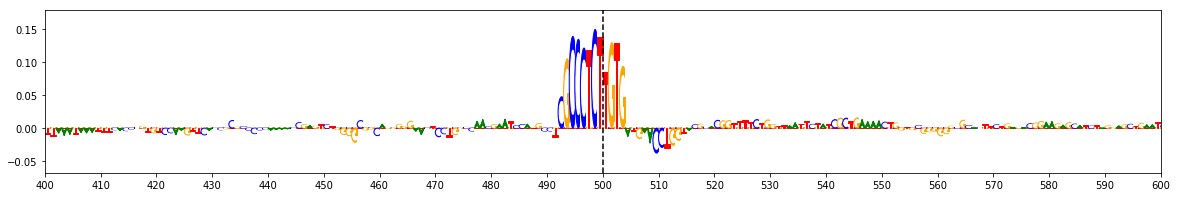

Noneffect Allele: C   ||  Explain Score: 0.5651   ||  Center / 200bp: 0.513
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


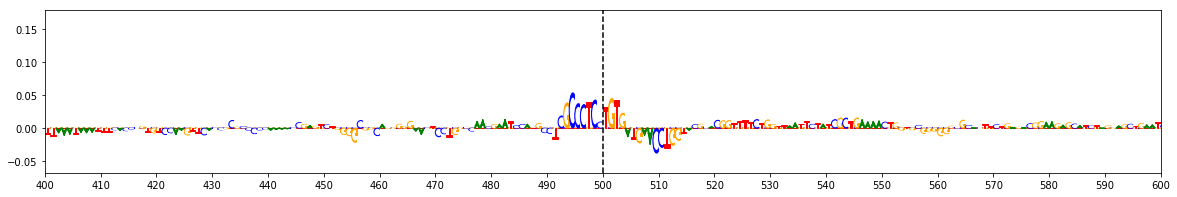

Allele Ratio : 2.7145   ||   Allele Difference : 1.0052  ||  ISM Score : 1.5699  ||  deltaSVM Score : 9.0046


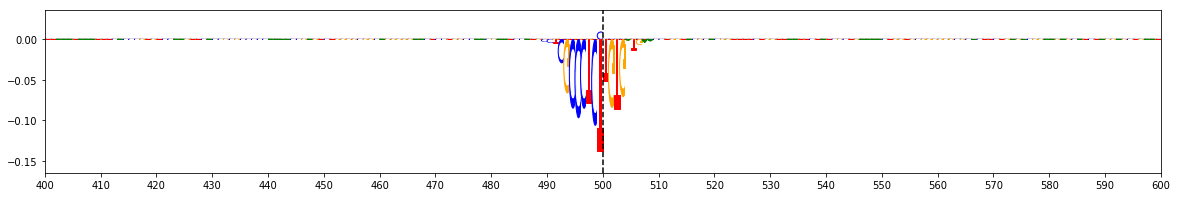


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17167632   ||    chr5 : 134594837 - 134594838   ||    Locus: 369   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.15E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.1173   ||  Center / 200bp: 0.3766
Effect Sequence: TCTACCTTGGCTTGGAAAAC


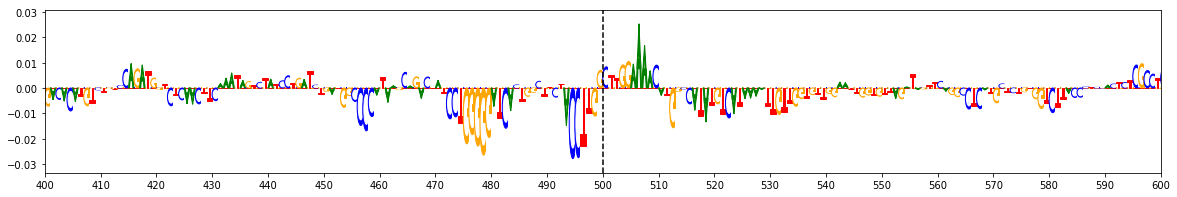

Noneffect Allele: A   ||  Explain Score: 0.0285   ||  Center / 200bp: 0.1278
Noneffect Sequence: TCTACCTTGACTTGGAAAAC


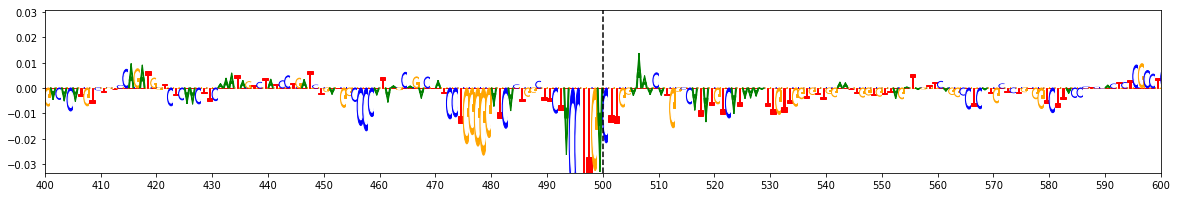

Allele Ratio : 4.1222   ||   Allele Difference : 0.3152  ||  ISM Score : 0.4914  ||  deltaSVM Score : 2.8628


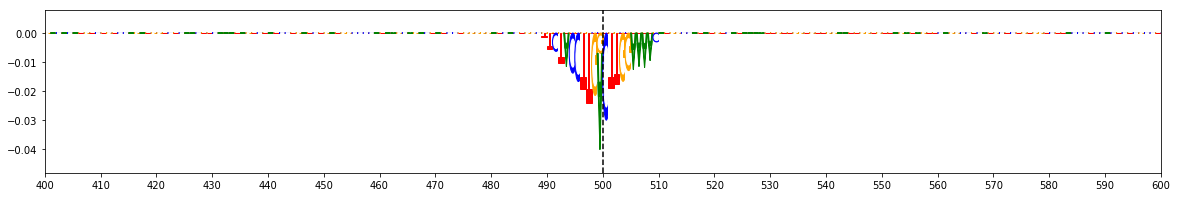


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs75541595   ||    chr4 : 90290372 - 90290373   ||    Locus: 353   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  5.30E-09

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7267   ||  Center / 200bp: 0.6834
Effect Sequence: CCAATGCCAGTATGTGGTTT


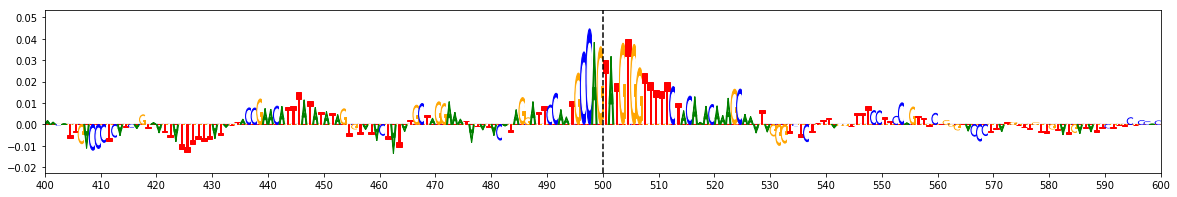

Noneffect Allele: A   ||  Explain Score: 0.3892   ||  Center / 200bp: 0.5363
Noneffect Sequence: CCAATGCCAATATGTGGTTT


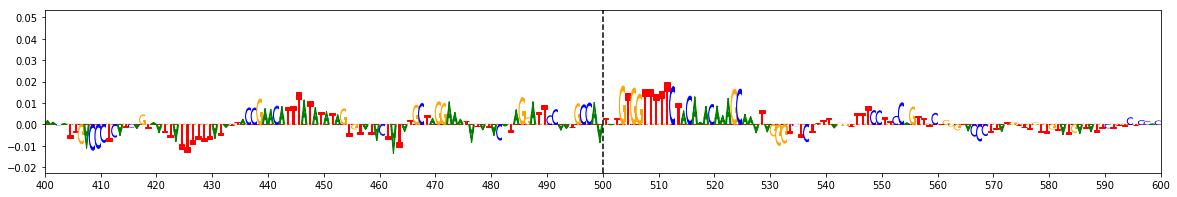

Allele Ratio : 1.8668   ||   Allele Difference : 0.3519  ||  ISM Score : 0.553  ||  deltaSVM Score : 3.166


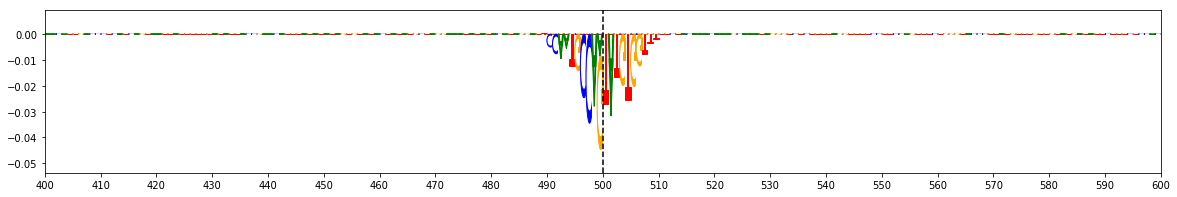


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6779394   ||    chr3 : 49120337 - 49120338   ||    Locus: 305   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.91E-03
Nalls_23andMe 		  5.91E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.306   ||  Center / 200bp: 0.4952
Effect Sequence: CTGCCACCGGCGCCTCCTTC


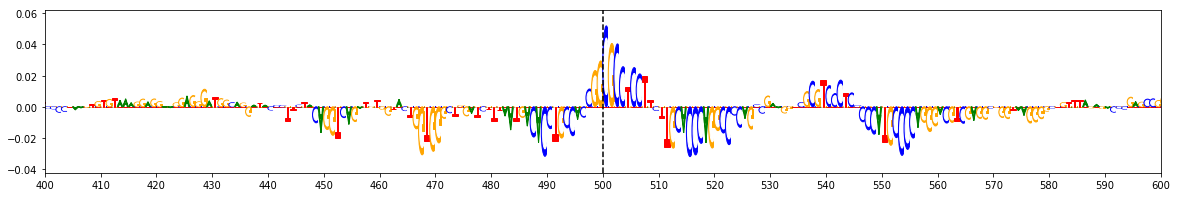

Noneffect Allele: A   ||  Explain Score: 0.1201   ||  Center / 200bp: 0.2782
Noneffect Sequence: CTGCCACCGACGCCTCCTTC


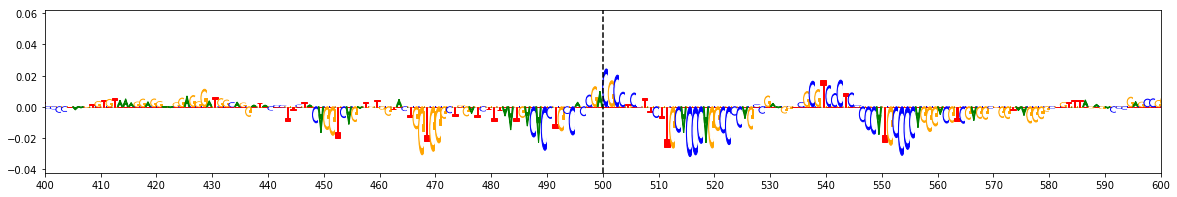

Allele Ratio : 2.5469   ||   Allele Difference : 0.1511  ||  ISM Score : 0.2372  ||  deltaSVM Score : 1.3437


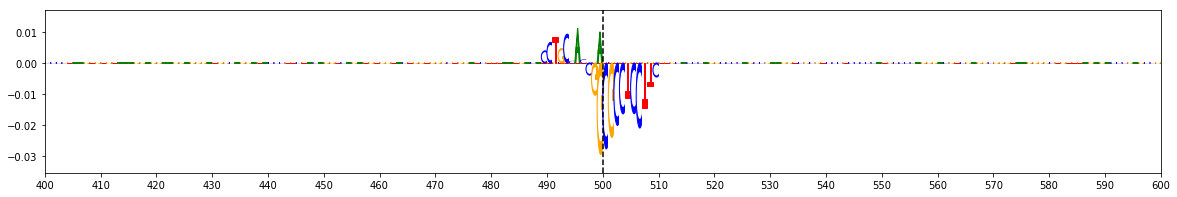


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4143315   ||    chr11 : 83780713 - 83780714   ||    Locus: 29   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  3.00E-02
Nalls_23andMe 		  3.00E-02

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.8607   ||  Center / 200bp: 0.6443
Effect Sequence: TTAGATGGGCGGGGTAGACA


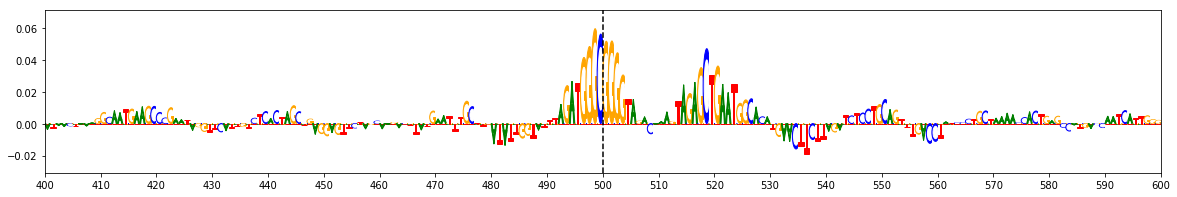

Noneffect Allele: A   ||  Explain Score: 0.4948   ||  Center / 200bp: 0.5102
Noneffect Sequence: TTAGATGGGAGGGGTAGACA


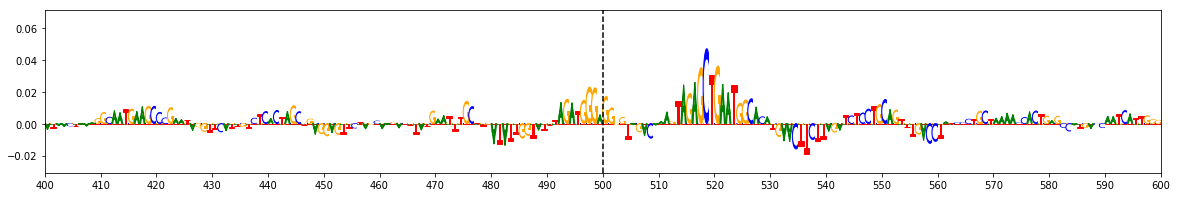

Allele Ratio : 1.7396   ||   Allele Difference : 0.3959  ||  ISM Score : 0.6165  ||  deltaSVM Score : 3.5211


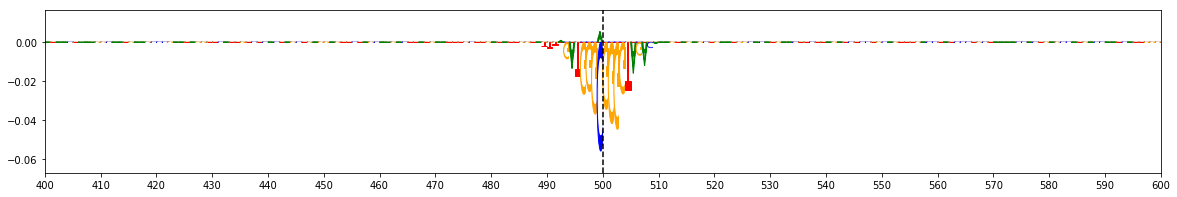


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3857059   ||    chr4 : 89754086 - 89754087   ||    Locus: 339   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.67E-19

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5927   ||  Center / 200bp: 0.5087
Effect Sequence: GAGGATACAGCTGAGAAGGC


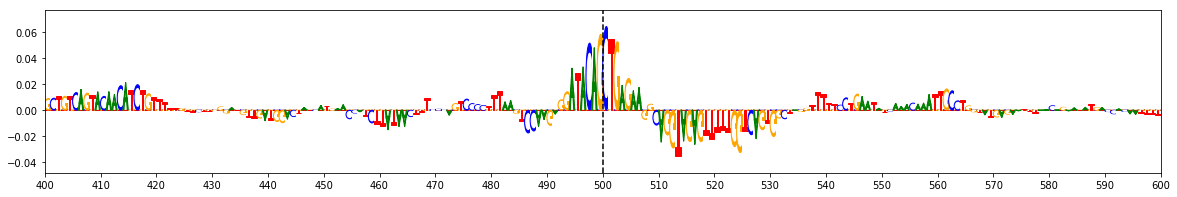

Noneffect Allele: A   ||  Explain Score: 0.2713   ||  Center / 200bp: 0.3216
Noneffect Sequence: GAGGATACAACTGAGAAGGC


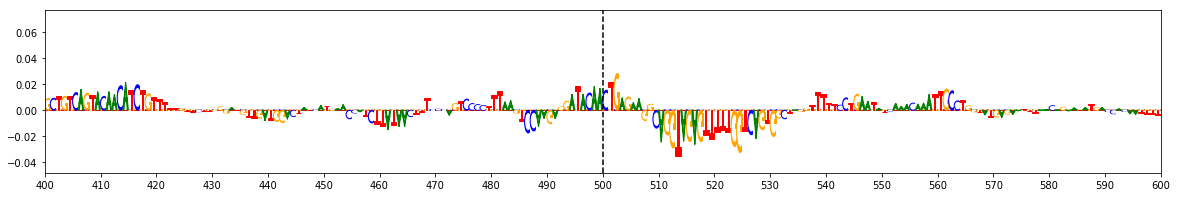

Allele Ratio : 2.185   ||   Allele Difference : 0.3258  ||  ISM Score : 0.5087  ||  deltaSVM Score : 2.9025


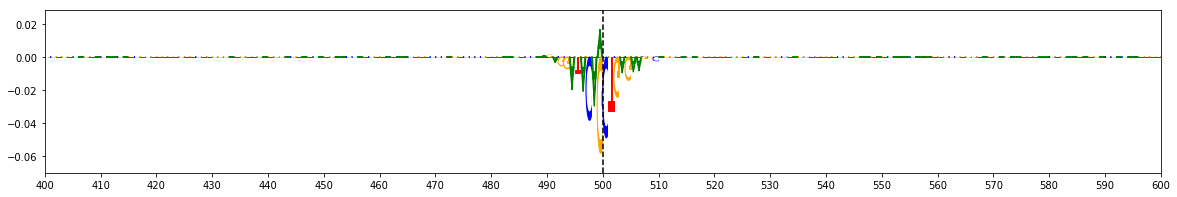


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3775427   ||    chr4 : 89765967 - 89765968   ||    Locus: 340   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.74E-12

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5932   ||  Center / 200bp: 0.4719
Effect Sequence: AAAAATTATGTAATGCAATG


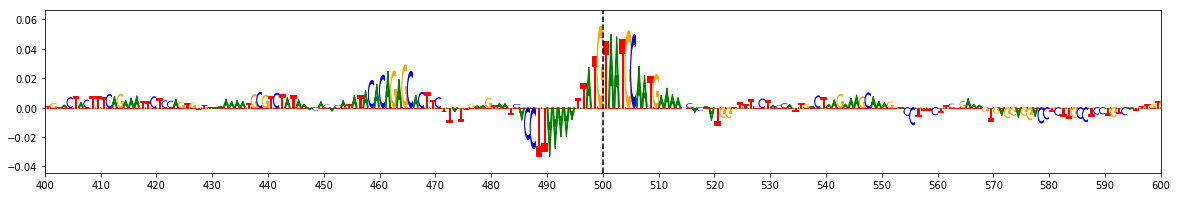

Noneffect Allele: A   ||  Explain Score: 0.2555   ||  Center / 200bp: 0.2786
Noneffect Sequence: AAAAATTATATAATGCAATG


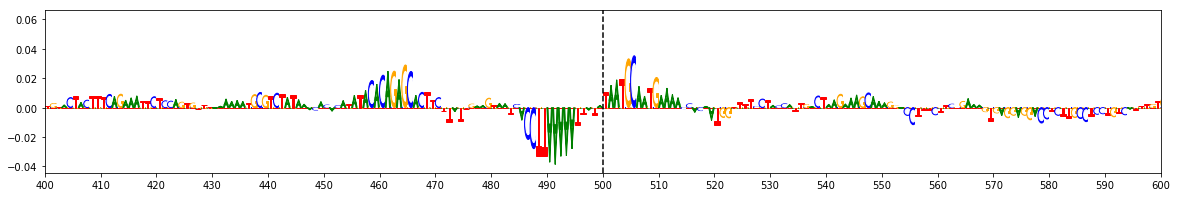

Allele Ratio : 2.3217   ||   Allele Difference : 0.4242  ||  ISM Score : 0.6654  ||  deltaSVM Score : 3.8575


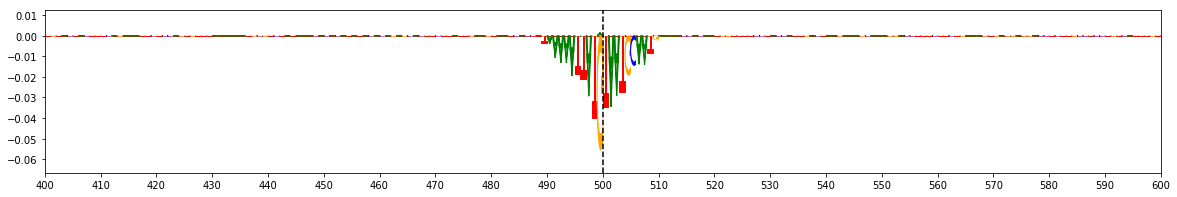


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 258   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8359   ||  Center / 200bp: 0.6262
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


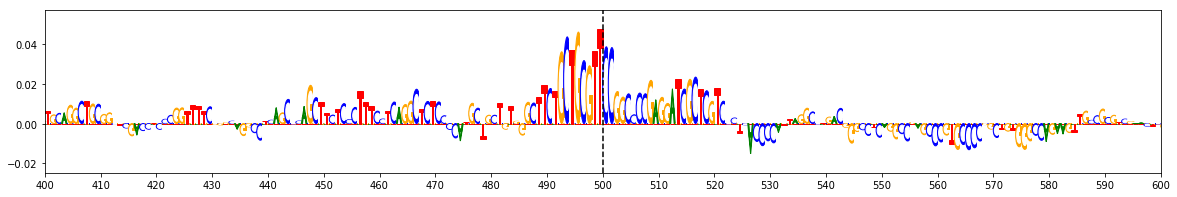

Noneffect Allele: C   ||  Explain Score: 0.4908   ||  Center / 200bp: 0.4962
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


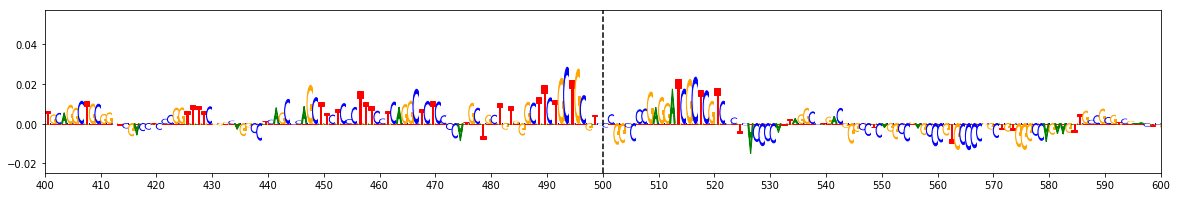

Allele Ratio : 1.7032   ||   Allele Difference : 0.3812  ||  ISM Score : 0.6024  ||  deltaSVM Score : 3.4669


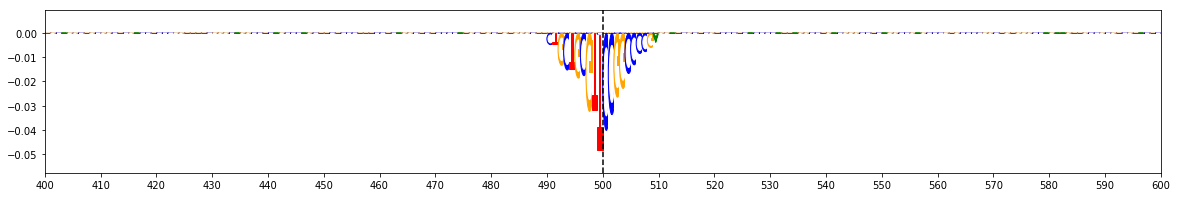


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1140239   ||    chr16 : 30010080 - 30010081   ||    Locus: 59   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.40E-03
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Effect Allele: NAN   ||  Explain Score: 0.4826   ||  Center / 200bp: 0.6598
Effect Sequence: CCCCGCCGCACCCGCCGCCC


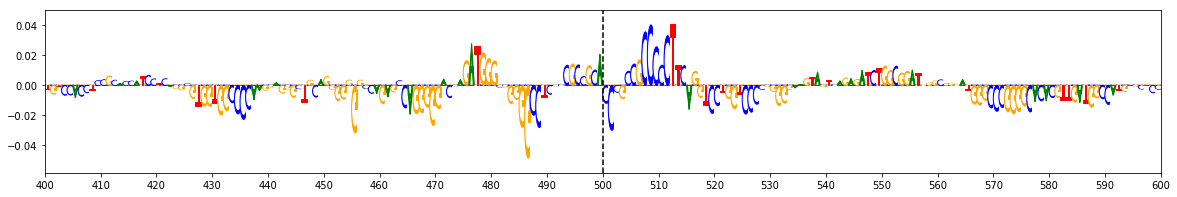

Noneffect Allele: NAN   ||  Explain Score: 0.3068   ||  Center / 200bp: 0.5629
Noneffect Sequence: CCCCGCCGCCCCCGCCGCCC


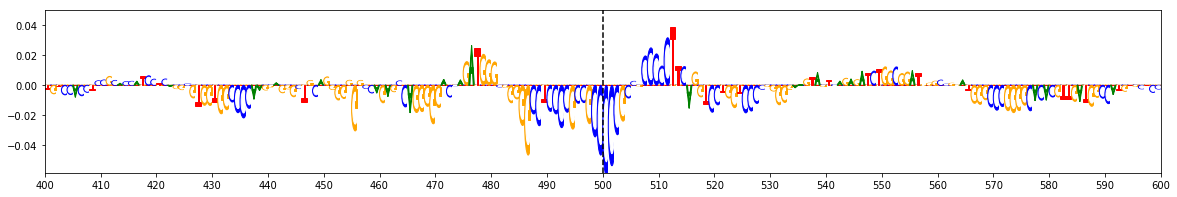

Allele Ratio : 1.573   ||   Allele Difference : 0.5285  ||  ISM Score : 0.7965  ||  deltaSVM Score : 5.1483


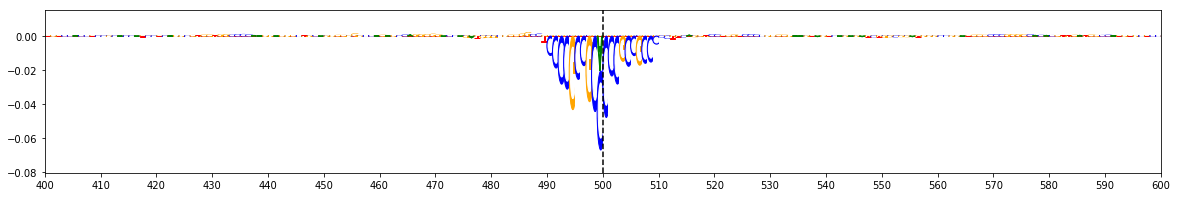


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7245611   ||    chr19 : 44954309 - 44954310   ||    Locus: 245   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  6.09E-12
Alzheimers_Lambert_2013 	  4.58E-11

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.2927   ||  Center / 200bp: 0.3704
Effect Sequence: GTGGTGGCGCGCTCCTGTAA


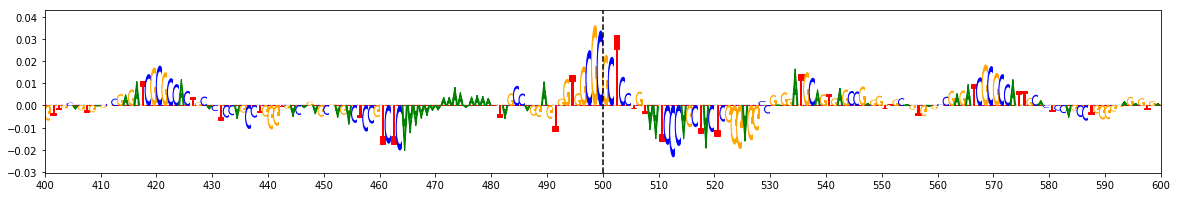

Noneffect Allele: T   ||  Explain Score: 0.1151   ||  Center / 200bp: 0.1876
Noneffect Sequence: GTGGTGGCGTGCTCCTGTAA


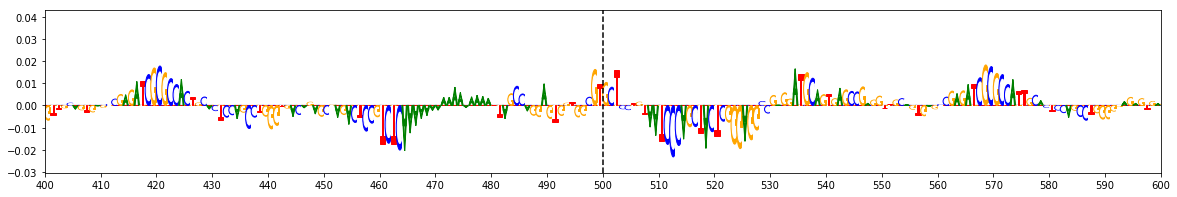

Allele Ratio : 2.5436   ||   Allele Difference : 0.1884  ||  ISM Score : 0.3757  ||  deltaSVM Score : 2.1416


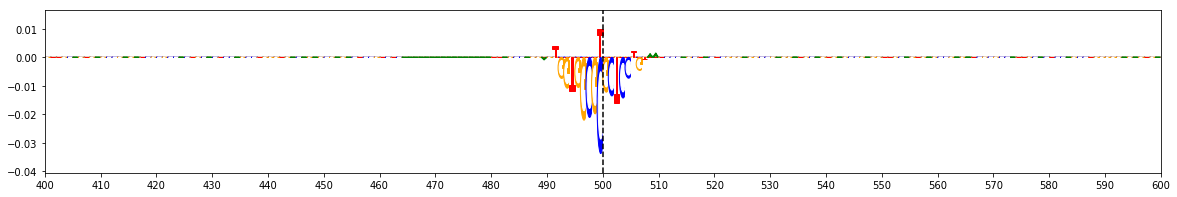


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7242459   ||    chr18 : 51153618 - 51153619   ||    Locus: 202   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.10E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.2609   ||  Center / 200bp: 0.5206
Effect Sequence: CCTGCCTCTCCCTAGGCCTG


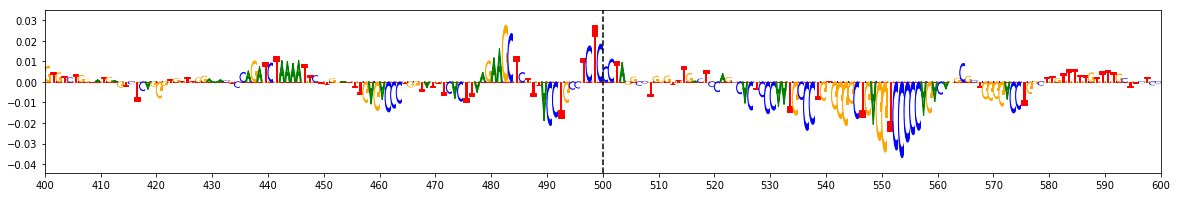

Noneffect Allele: A   ||  Explain Score: 0.1449   ||  Center / 200bp: 0.3759
Noneffect Sequence: CCTGCCTCTACCTAGGCCTG


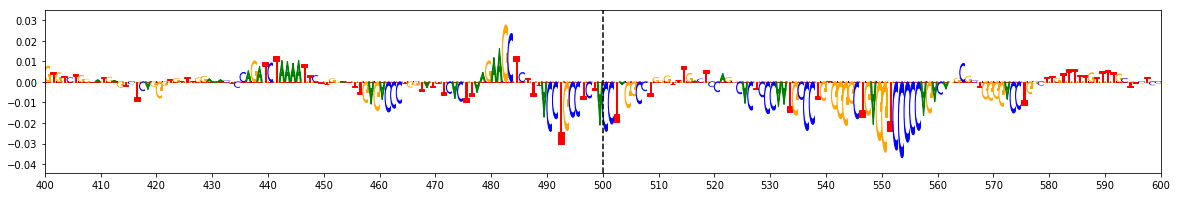

Allele Ratio : 1.7999   ||   Allele Difference : 0.3091  ||  ISM Score : 0.482  ||  deltaSVM Score : 2.7734


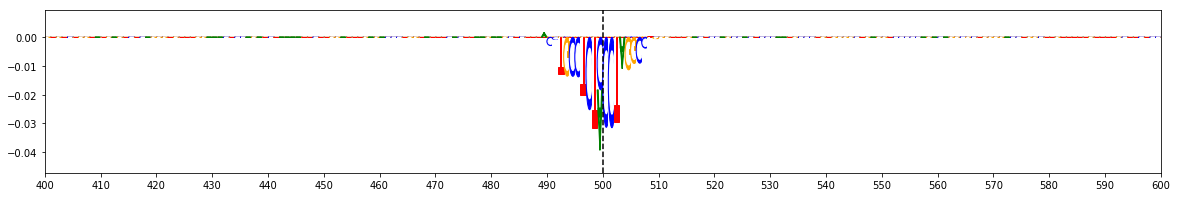


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 285   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7836   ||  Center / 200bp: 0.5062
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


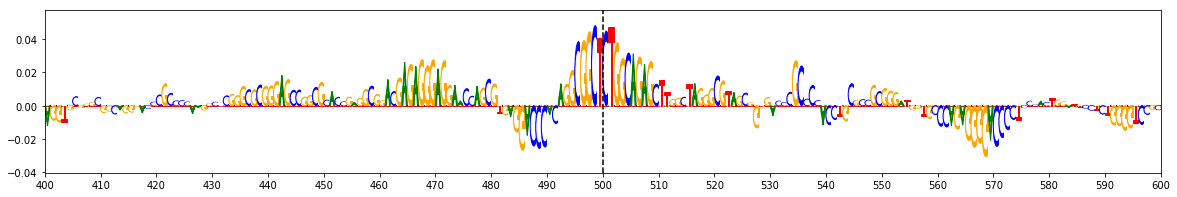

Noneffect Allele: C   ||  Explain Score: 0.4241   ||  Center / 200bp: 0.3557
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


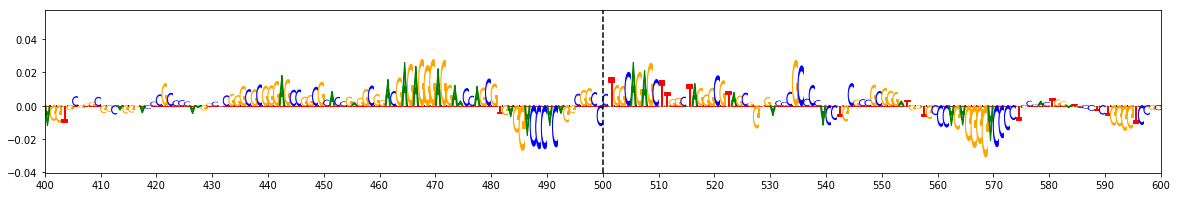

Allele Ratio : 1.8475   ||   Allele Difference : 0.4123  ||  ISM Score : 0.6576  ||  deltaSVM Score : 3.8092


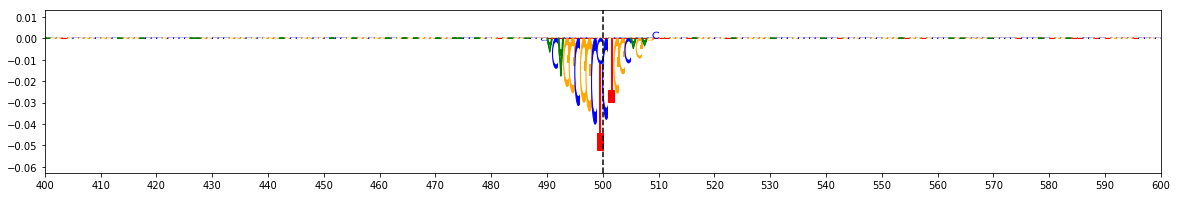


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 186   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.0961   ||  Center / 200bp: 0.4507
Effect Sequence: GCCCTCCTGCGCCACCTACA


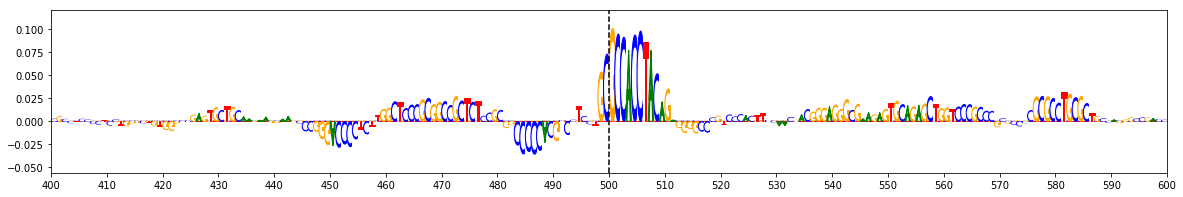

Noneffect Allele: A   ||  Explain Score: 0.5406   ||  Center / 200bp: 0.2877
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


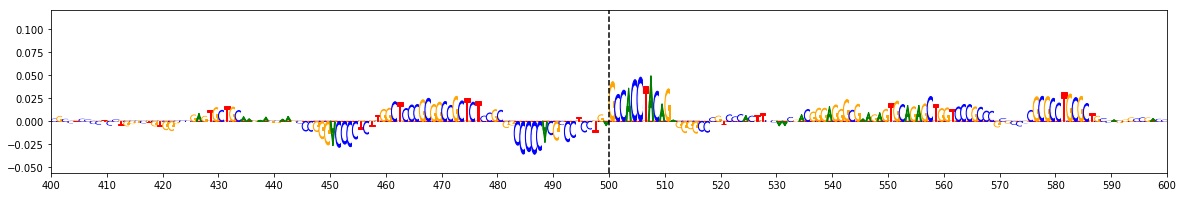

Allele Ratio : 2.0274   ||   Allele Difference : 0.6102  ||  ISM Score : 0.9688  ||  deltaSVM Score : 5.6061


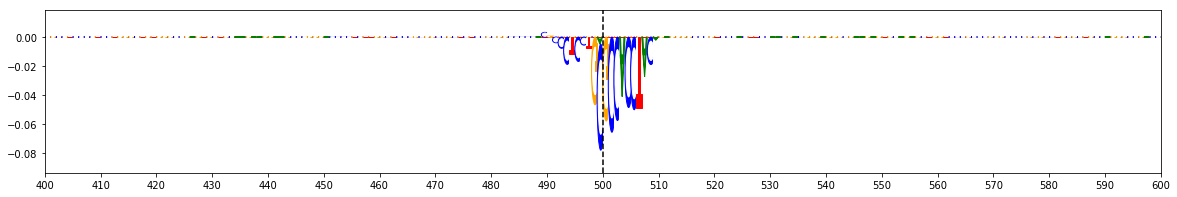


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76311426   ||    chr17 : 45741323 - 45741324   ||    Locus: 112   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.91E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7114   ||  Center / 200bp: 0.6524
Effect Sequence: GGGAGGCGATGGTGCTCCAT


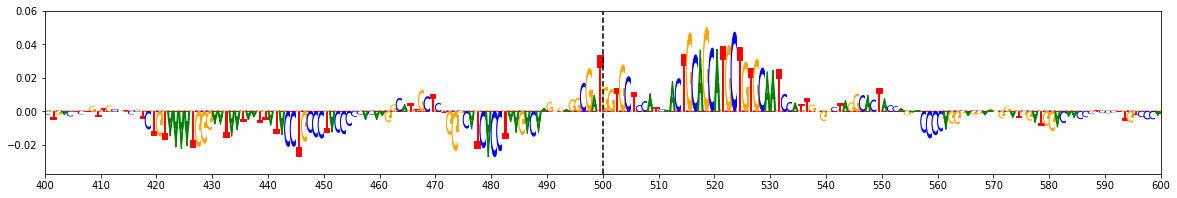

Noneffect Allele: G   ||  Explain Score: 0.5175   ||  Center / 200bp: 0.577
Noneffect Sequence: GGGAGGCGAGGGTGCTCCAT


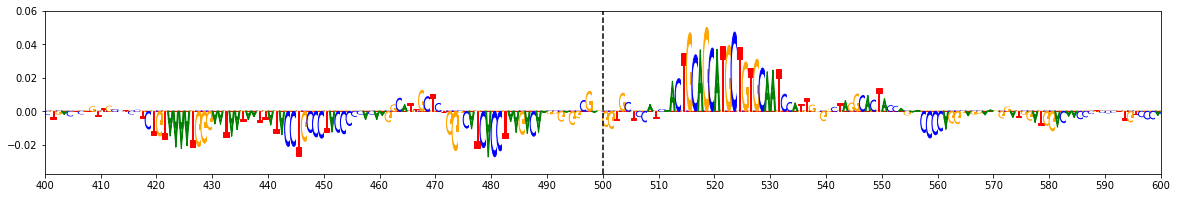

Allele Ratio : 1.3746   ||   Allele Difference : 0.2604  ||  ISM Score : 0.4085  ||  deltaSVM Score : 2.3752


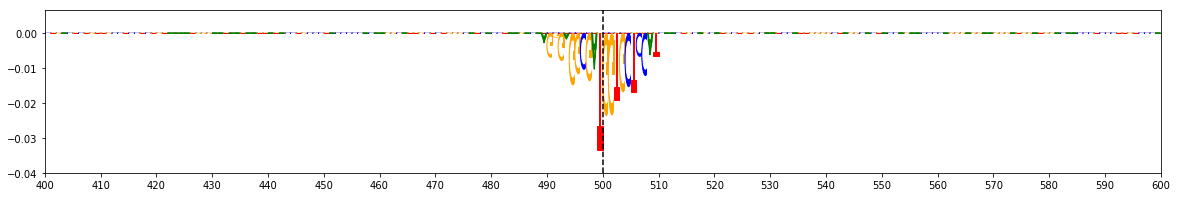


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs73272053   ||    chr7 : 23115905 - 23115906   ||    Locus: 383   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Effect Allele: NAN   ||  Explain Score: 0.6719   ||  Center / 200bp: 0.5832
Effect Sequence: TCAGCTACCGGGTATCATAG


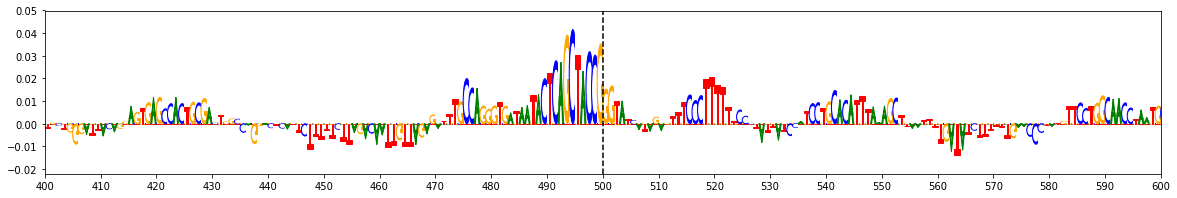

Noneffect Allele: NAN   ||  Explain Score: 0.4445   ||  Center / 200bp: 0.4808
Noneffect Sequence: TCAGCTACCAGGTATCATAG


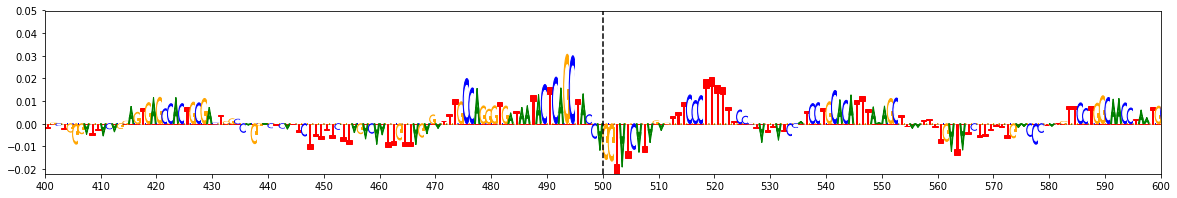

Allele Ratio : 1.5117   ||   Allele Difference : 0.3702  ||  ISM Score : 0.5775  ||  deltaSVM Score : 3.3335


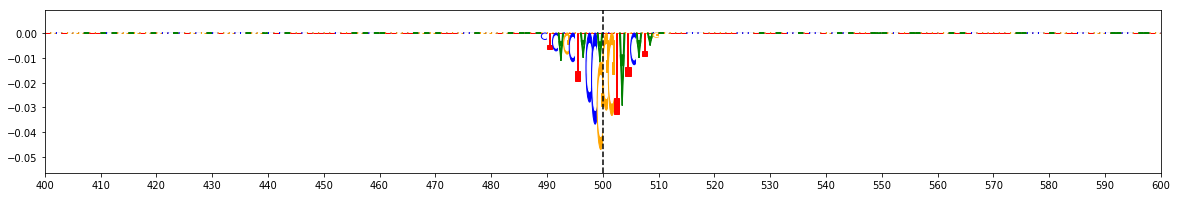


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 158   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.2674   ||  Center / 200bp: 0.5683
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


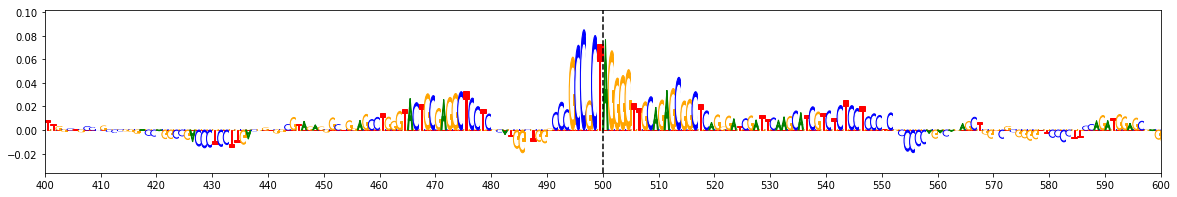

Noneffect Allele: G   ||  Explain Score: 0.8251   ||  Center / 200bp: 0.4617
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


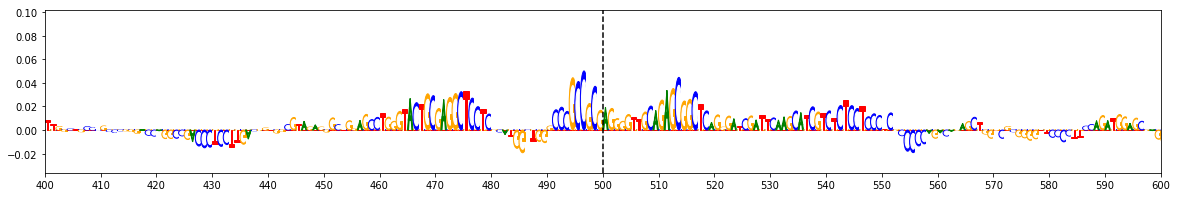

Allele Ratio : 1.5362   ||   Allele Difference : 0.4421  ||  ISM Score : 0.6904  ||  deltaSVM Score : 3.921


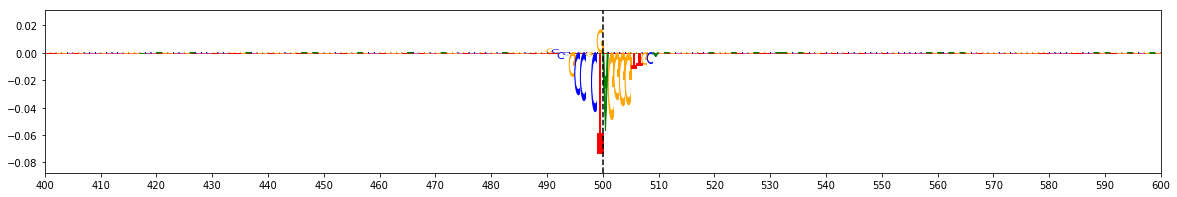


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11691237   ||    chr2 : 127084806 - 127084807   ||    Locus: 273   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  5.22E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9617   ||  Center / 200bp: 0.769
Effect Sequence: CTCTGAGCCTATTGCAGTGT


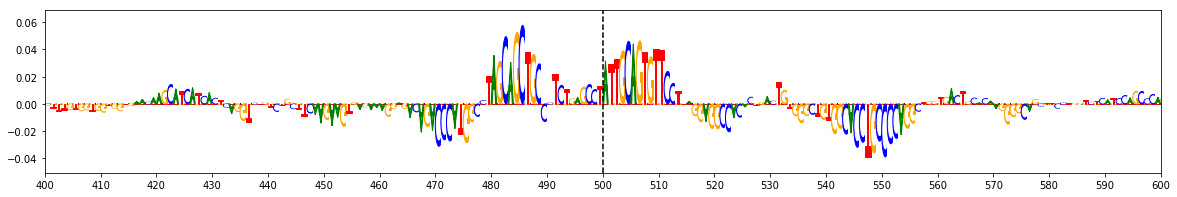

Noneffect Allele: C   ||  Explain Score: 0.8494   ||  Center / 200bp: 0.7463
Noneffect Sequence: CTCTGAGCCCATTGCAGTGT


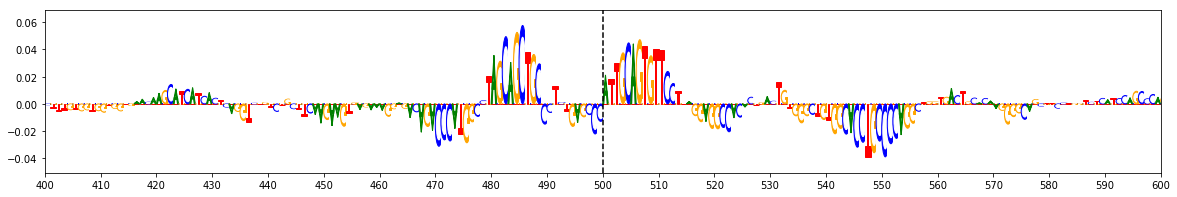

Allele Ratio : 1.1322   ||   Allele Difference : 0.2077  ||  ISM Score : 0.3261  ||  deltaSVM Score : 1.8922


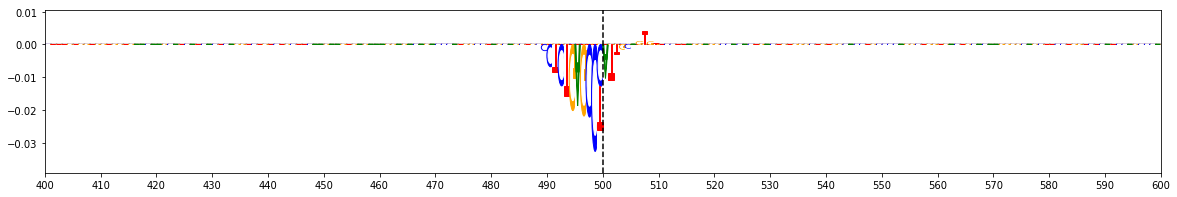


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 7   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.91E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.5871   ||  Center / 200bp: 0.6562
Effect Sequence: GGATGATTCAGATAATGTCT


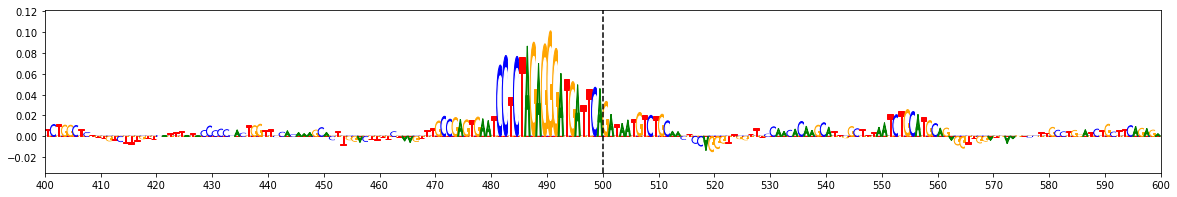

Noneffect Allele: C   ||  Explain Score: 1.2729   ||  Center / 200bp: 0.6046
Noneffect Sequence: GGATGATTCCGATAATGTCT


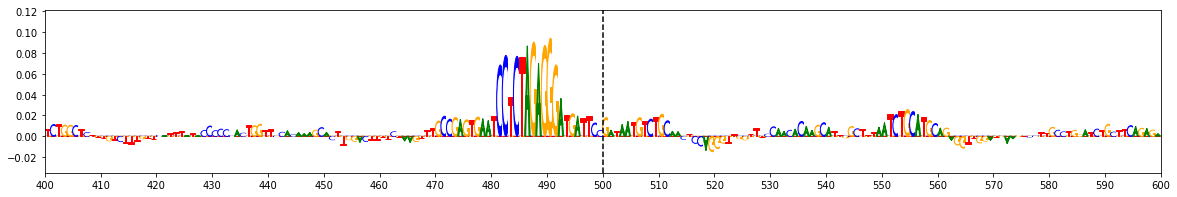

Allele Ratio : 1.2468   ||   Allele Difference : 0.3143  ||  ISM Score : 0.4893  ||  deltaSVM Score : 2.915


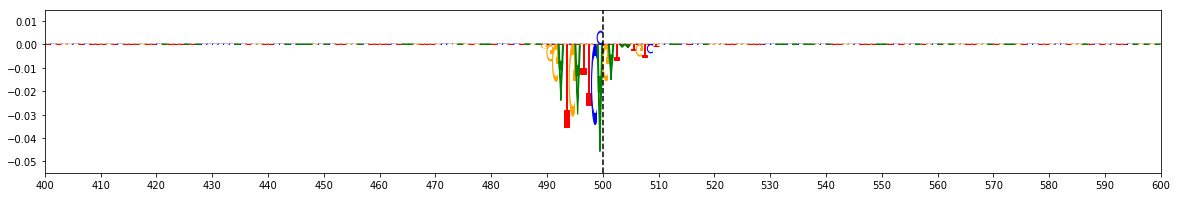


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs28399596   ||    chr19 : 44806777 - 44806778   ||    Locus: 226   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.08E-14
Alzheimers_Kunkle_2019 		  2.07E-19

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.6015   ||  Center / 200bp: 0.6195
Effect Sequence: GGCAACATCATGCAGTGGCA


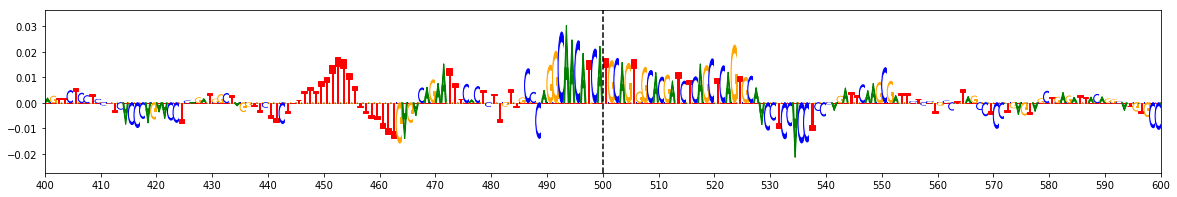

Noneffect Allele: G   ||  Explain Score: 0.4571   ||  Center / 200bp: 0.5531
Noneffect Sequence: GGCAACATCGTGCAGTGGCA


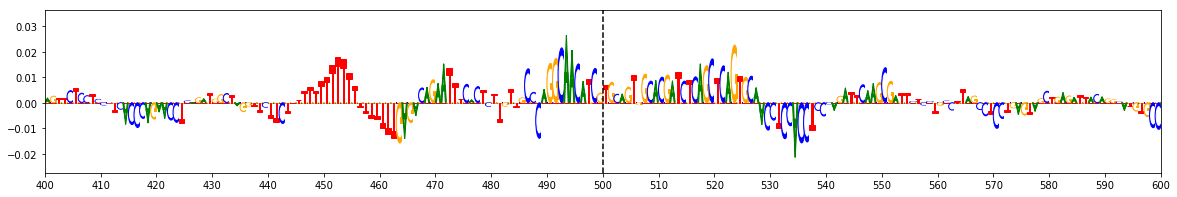

Allele Ratio : 1.3159   ||   Allele Difference : 0.1452  ||  ISM Score : 0.271  ||  deltaSVM Score : 1.5633


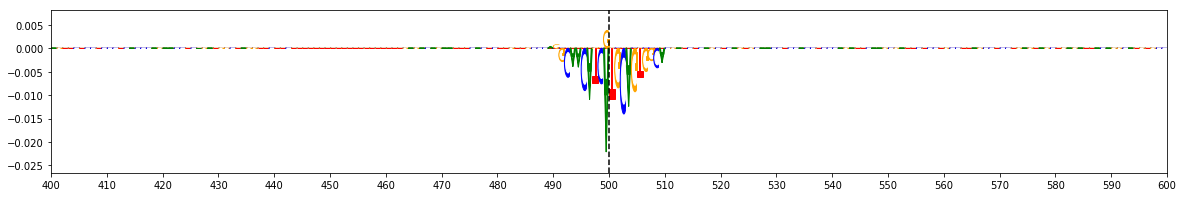


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()